# Entrenamiento y análisis de redes neuronales para el reconocimiento de enfermedades

In [1]:
import sys
print(sys.version, sys.version_info)

3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)] sys.version_info(major=3, minor=9, micro=5, releaselevel='final', serial=0)


## Preprocesamiento

En esta primera sección se va a realizar la preparación y preprocesamiento de los datos con los que se va a trabajar. Se va a realizar un preprocesamiento de tanto los **"datos numéricos"** como de las **imágenes** aunque el principal objetivo es trabajar con estas últimas. Los **"datos numéricos"** podrán ser utilizados más adelante en el proyecto en caso de que se trabaje con arquitecturas que combinen de forma paralela el procesamiento de imágenes mediante **Capas Convolucionales Bidimensionales** con **Capas Densas** para los **"datos numéricos"**.

En primer lugar vamos a importar todo lo necesario para el proyecto así como definir algunas de las variables o funciones que se usarán.

In [1]:
# En primer lugar importamos todo lo que vamos a usar a lo largo del notebook
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage as sima
import sklearn
from sklearn.model_selection import train_test_split
import datetime
import mplcyberpunk
from tensorflow.keras import datasets, layers, models, mixed_precision
from IPython import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Establecemos una paleta de colores que utilizaremos en las gráficas, así como el tamaño de las mismas y el estilo que se les va a aplicar
colors = [
    '#08F7FE', # cyan
    '#FE53BB', # pink
    '#F5D300', # yellow
    '#00ff41', # green
    '#cb0c59', # red
    '#fc5e03', # orange
    '#fc03fc', # neon pink
    '#005eff', # dark blue
]
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use("cyberpunk")
# Definimos algunas de las rutas usadas en el proyecto
PREPROCESSED_IMAGES_PATH = './Repositorio/PreprocessedImages'
IMAGES_PATH = './Repositorio/Images'
IMAGE_NPY = './Repositorio/NPY'
IMAGE_NPY_BINARY = './Repositorio/NPY_Binary'
DOWNSCALE = 8
# Creamos algunas funciones para ayudar en la representación de los datasets
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_grthan(s, n=0.8, props=''):
    return np.where(s >= n, props, '')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Cargamos el Dataframe con la información de las radiografías

In [2]:
df = pd.read_csv("./Repositorio/Data_Entry_2017.csv")
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


Como tenemos una solo columna con los nombres de todas las enfermedades que tiene cada persona tenemos que seccionar ésta en una columna por cada enfermedad y poner a 0 a aquella que no tiene y a 1 la que si. Esto es conocido como **One Hot Encoding**, normalmente se puede realizar con funciones ya establecidas en librerías como **scikitlearn** pero por como tenemos los datos vamos a tener que hacerlo nosotros sin ayuda de funciones de librerías externas.

In [3]:
array = []
for sample in df["Finding Labels"]:
    s = sample.split("|")
    r = {}
    for i in s:
        r[i] = 1
    array.append(r)
    
conditions = pd.DataFrame(array).fillna(0.0).astype(int)

df = pd.concat([df, conditions], axis = 1)
df.drop(columns = ["Finding Labels"], inplace = True)
df

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,1,30801,39,M,PA,2048,2500,0.168,0.168,...,0,1,0,0,0,0,1,0,0,0
112116,00030802_000.png,0,30802,29,M,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,30803,42,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,30804,30,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0


A continuación vamos a verificar que no haya edades no válidas, éstas pueden ser aquellas que posean un valor menor a 1 o aquellas muy superiores a 100.

In [4]:
temp = df[df["Patient Age"] < 1]
temp

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation


Podemos ver que no hay casos de pacientes cuya edad sea inferior a 1.

In [5]:
temp = df[df["Patient Age"] > 100]
temp

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
20852,00005567_000.png,0,5567,412,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,1,0,0,0
46965,00011973_002.png,2,11973,414,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,1,0
48284,00012238_010.png,10,12238,148,M,PA,2992,2991,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
55742,00013950_000.png,0,13950,148,M,PA,2964,2939,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
58650,00014520_026.png,26,14520,150,M,PA,2992,2991,0.143,0.143,...,1,1,0,0,0,0,0,0,0,0
62929,00015558_000.png,0,15558,149,M,PA,2992,2991,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
74884,00018366_044.png,44,18366,152,F,PA,2302,2991,0.143,0.143,...,0,0,0,0,1,0,0,0,0,0
78795,00019346_000.png,0,19346,151,F,PA,2678,2774,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
84810,00020900_002.png,2,20900,411,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,0,0
85404,00021047_002.png,2,21047,412,M,AP,3056,2544,0.139,0.139,...,0,1,0,0,0,1,0,0,0,0


Como hemos localizado personas con edades imposibles, las eliminamos del dataframe. Además aprovechamos también para eliminar algunos de los campos que no nos van a aportar información.

In [6]:
df.drop(index = temp.index, inplace = True)
df.drop(["OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Follow-up #", "Patient ID"], axis = 1, inplace = True)

df["Unnamed: 11"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Unnamed: 11, dtype: float64

In [7]:
df.drop(["Unnamed: 11"], axis = 1, inplace = True)

Una vez hemos limpiado un poco nuestro conjunto de datos, podemos visualizar la cantidad de imágenes asociadas a una enfermedad que tenemos. Ésto nos va a ayudar a saber si nuestros datos están muy desbalanceados, en cuyo caso los balancearemos.

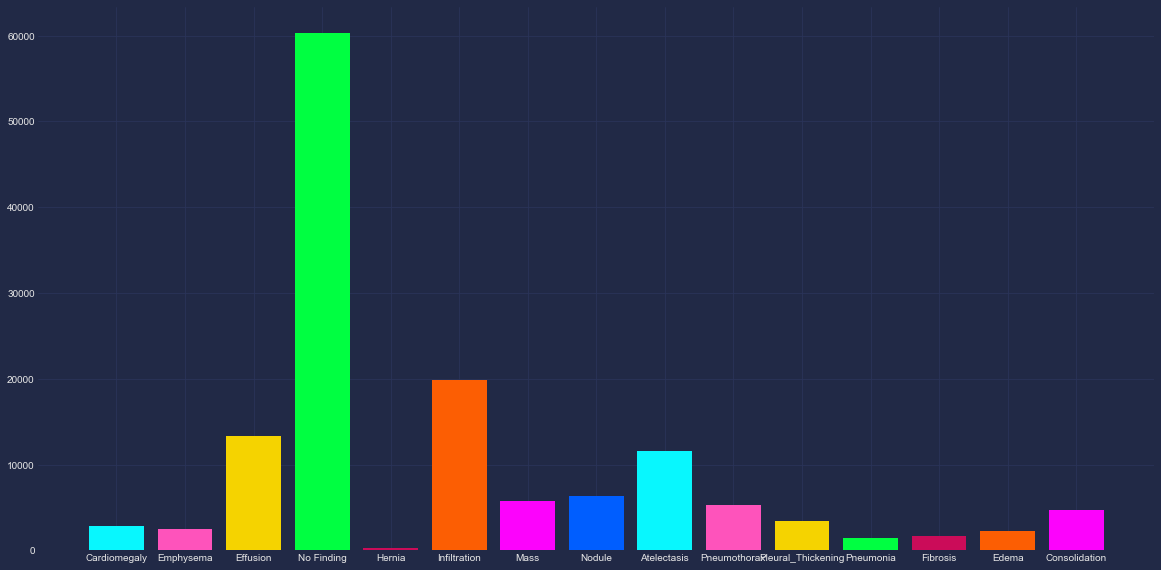

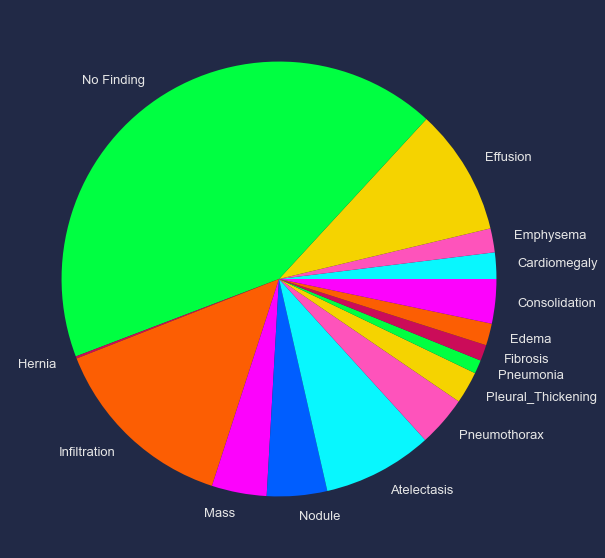

In [8]:
diccionario = {column : len([x for x in df[column] if x>0]) for column in df.columns[4:]}

plt.bar(range(len(diccionario)), list(diccionario.values()), tick_label=list(diccionario.keys()), color = colors)
plt.show()

plt.pie(diccionario.values(), labels = diccionario.keys(), textprops={'fontsize': 13}, colors = colors)
plt.show()

Como se puede observar el dataset esta muy desbalanceado. Tenemos enfermedades con muy pocos casos como por ejemplo:  
**Hernia:     227**  
**Fibrosis:   1686**  
**Pneumonia:  1430**  
Y otro casos con muchas como pasa con:  
**No finding:     60353**  
**Infiltration:   19891**  
Debido a esto y a que en una primera prueba en la que usaba todas las imágenes mi ordenador no era capaz de trabajar correctamente con los datos, vamos a balancearlos.  
Comenzaremos eliminando aquellos cuyas enfermedades no lleguen a los 4000 casos:

In [9]:
for k, v in diccionario.items():
    if v < 4000:
        df.drop(df[df[k] == 1].index, inplace=True)
        df.drop([k], axis = 1, inplace=True)
        
df

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
3,00000002_000.png,81,M,PA,0,1,0,0,0,0,0,0
12,00000004_000.png,82,M,AP,0,0,0,1,1,0,0,0
13,00000005_000.png,69,F,PA,0,1,0,0,0,0,0,0
14,00000005_001.png,69,F,AP,0,1,0,0,0,0,0,0
15,00000005_002.png,69,F,AP,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,39,M,PA,0,1,0,0,0,0,0,0
112116,00030802_000.png,29,M,PA,0,1,0,0,0,0,0,0
112117,00030803_000.png,42,F,PA,0,1,0,0,0,0,0,0
112118,00030804_000.png,30,F,PA,0,1,0,0,0,0,0,0


Ahora vamos a ver como de dependientes son unas enfermedades de otras, para ello vamos a ver el número casos de más de una afección para cada una de las enfermedades.

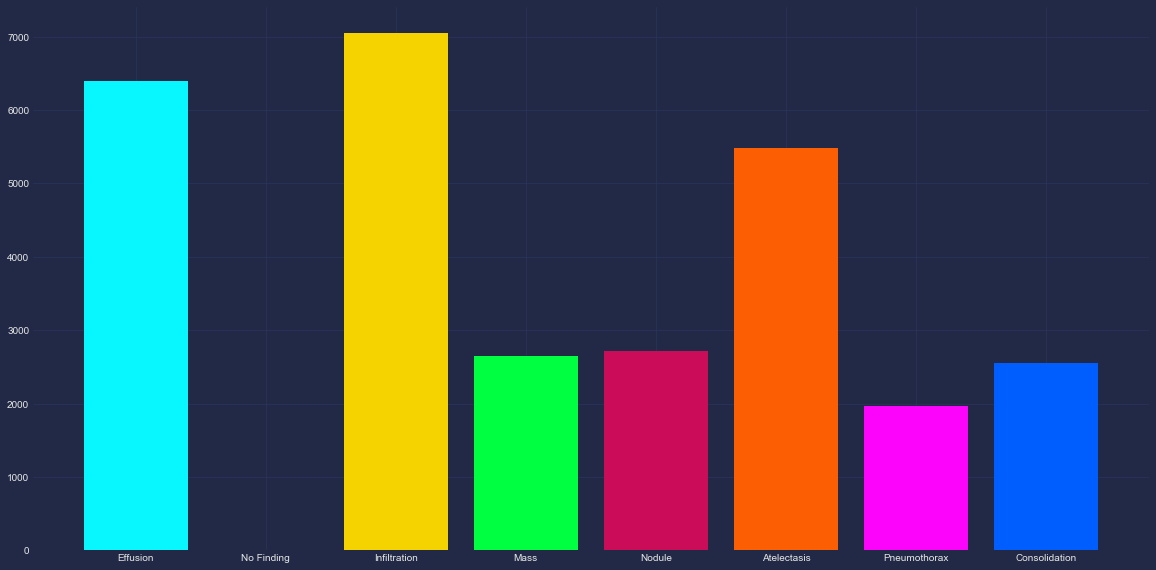

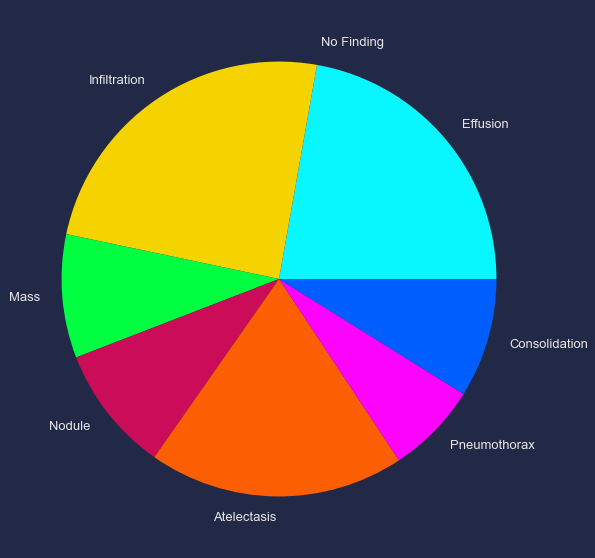

In [10]:
enfermedades = {column:0 for column in df.columns[4:]}

for x in df.iterrows():
    total = 0
    for j in x[1][4:]:
        total += j
        
    if total > 1:
        for k, v in enfermedades.items():
            if df[k][x[0]] == 1:
                enfermedades[k] += 1

plt.bar(range(len(enfermedades)), list(enfermedades.values()), tick_label=list(enfermedades.keys()), color = colors)
plt.show()                
                
plt.pie(enfermedades.values(), labels = enfermedades.keys(), textprops={'fontsize': 13}, colors = colors)
plt.show()

Como se puede observar hay bastantes casos en los que los pacientes tienen más de una enfermedad, destacan sobretodo **Atelectasis**, **Infiltration** y **Effusion**.

<BarContainer object of 8 artists>

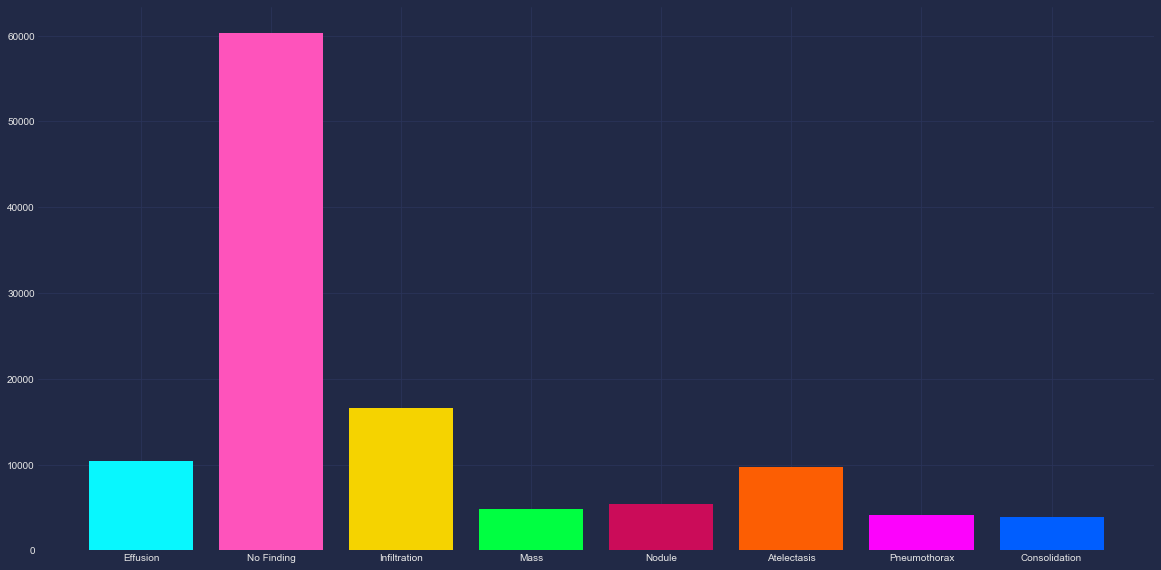

In [11]:
df_binary = df.copy(deep = True) # Esto servirá más adelante
total = {column : len([x for x in df[column] if x>0]) for column in df.columns[4:]}
plt.bar(range(len(total)), list(total.values()), tick_label=list(total.keys()), color = colors)

Si comparamos el número total de casos por enfermedad con el de casos que tienen más de una tenemos:

In [12]:
for k, v in enfermedades.items():
    print(k + ": " + str(round((v/total[k])*100, 2)) + "%")

Effusion: 61.8%
No Finding: 0.0%
Infiltration: 42.5%
Mass: 55.3%
Nodule: 50.07%
Atelectasis: 56.53%
Pneumothorax: 47.28%
Consolidation: 66.11%


Cada porcentaje representa la cantidad de casos de dicha enfermedad que además tiene alguna otra afección, con respecto al total de dicha enfermedad.  
Como se puede observar, hay una gran dependencia en los datos y no sería nada fácil borrar manteniendo un balanceo total de los mismos, por ello vamos a probar a reducir los datos intentando mantener un balance bueno.

Comenzamos creando una función que nos permite quedarnos con **N** casos de una determinada enfermedad.

In [13]:
def resizeSamples(df, column, number):
    # En primer lugar nos quedamos con todo el DataFrame que tenga la columna elegida
    aux = df[df[column]==1]
    # Las eliminamos del df original
    df.drop(index = aux.index, inplace = True)
    # Hacemos una selección aleatoria del conjunto
    aux = aux.sample(number, random_state = 42)
    # Concatenamos el resultado al df anterior
    df = pd.concat([df, aux])
    # Mezclamos para que no esten todas al final
    return df.sample(frac = 1, random_state = 42).reset_index(drop=True)

Ejecutamos la función anterior para quedarnos con cierta cantidad de cada enfermedad:

In [14]:
df = resizeSamples(df, "No Finding", 1200)
df

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,00027628_005.png,44,F,AP,1,0,0,0,0,0,0,0
1,00009667_004.png,86,M,AP,1,0,1,0,0,1,0,0
2,00026399_011.png,56,M,PA,1,0,1,0,0,0,1,0
3,00010830_001.png,61,M,PA,0,0,0,0,0,1,0,0
4,00001170_010.png,23,M,AP,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
39862,00005695_000.png,20,F,AP,1,0,0,0,0,0,0,0
39863,00009813_000.png,69,M,PA,0,0,1,0,1,0,0,0
39864,00030159_010.png,38,M,AP,1,0,0,0,0,0,0,0
39865,00000720_006.png,47,M,PA,1,0,1,0,0,0,0,0


In [15]:
df = resizeSamples(df, "Infiltration", 1200)
df = resizeSamples(df, "Atelectasis", 1200)
df = resizeSamples(df, "Effusion", 1200)
df = resizeSamples(df, "Mass", 1200)
df = resizeSamples(df, "Nodule", 1200)
df = resizeSamples(df, "Pneumothorax", 1200)
df = resizeSamples(df, "Consolidation", 1200)
df

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,00016053_000.png,23,F,PA,0,0,0,0,0,0,0,1
1,00026007_000.png,71,F,PA,0,1,0,0,0,0,0,0
2,00013128_015.png,64,M,PA,0,1,0,0,0,0,0,0
3,00014032_013.png,61,M,PA,0,0,0,0,0,0,1,0
4,00001724_002.png,42,F,PA,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,00016827_001.png,70,M,PA,0,1,0,0,0,0,0,0
7783,00018360_014.png,62,M,AP,1,0,0,0,0,0,0,0
7784,00022215_013.png,53,F,PA,1,0,0,0,0,0,0,0
7785,00021835_024.png,39,F,AP,0,0,0,0,0,0,0,1


Si le echamos un vistazo al dataset ahora esta mucho más equilibrado

<BarContainer object of 8 artists>

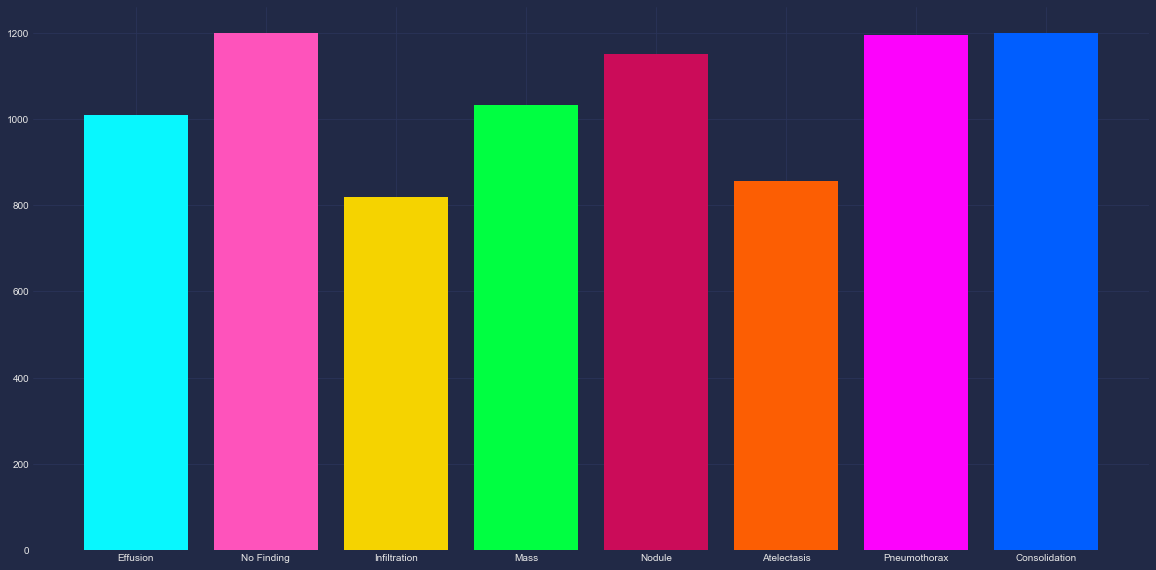

In [16]:
aux = {column : len([x for x in df[column] if x>0]) for column in df.columns[4:]}
plt.bar(range(len(aux)), list(aux.values()), tick_label=list(aux.keys()), color = colors)

Una vez hecho esto, vamos a intentar entender de forma visual las dependencias que tenemos entre las diferentes enfermedades y cómo estan relacionadas, para ello vamos a mostrar en un gráfico de barras apiladas en las que se muestren el número de casos de cada enfermedad con ella misma y con las demás.

In [17]:
def dependencies(column):
    aux = df[df[column]==1].cumsum()
    aux = aux.tail(1)
    aux.drop(["Image Index", "Patient Age",	"Patient Gender", "View Position"], axis = 1, inplace = True)
    aux["Name"] = column
    return aux

In [18]:
names = df.columns[4:]
dependencias = pd.DataFrame(columns=names)
for col in df.columns[4:]:
    dependencias = pd.concat([dependencias, dependencies(col)])

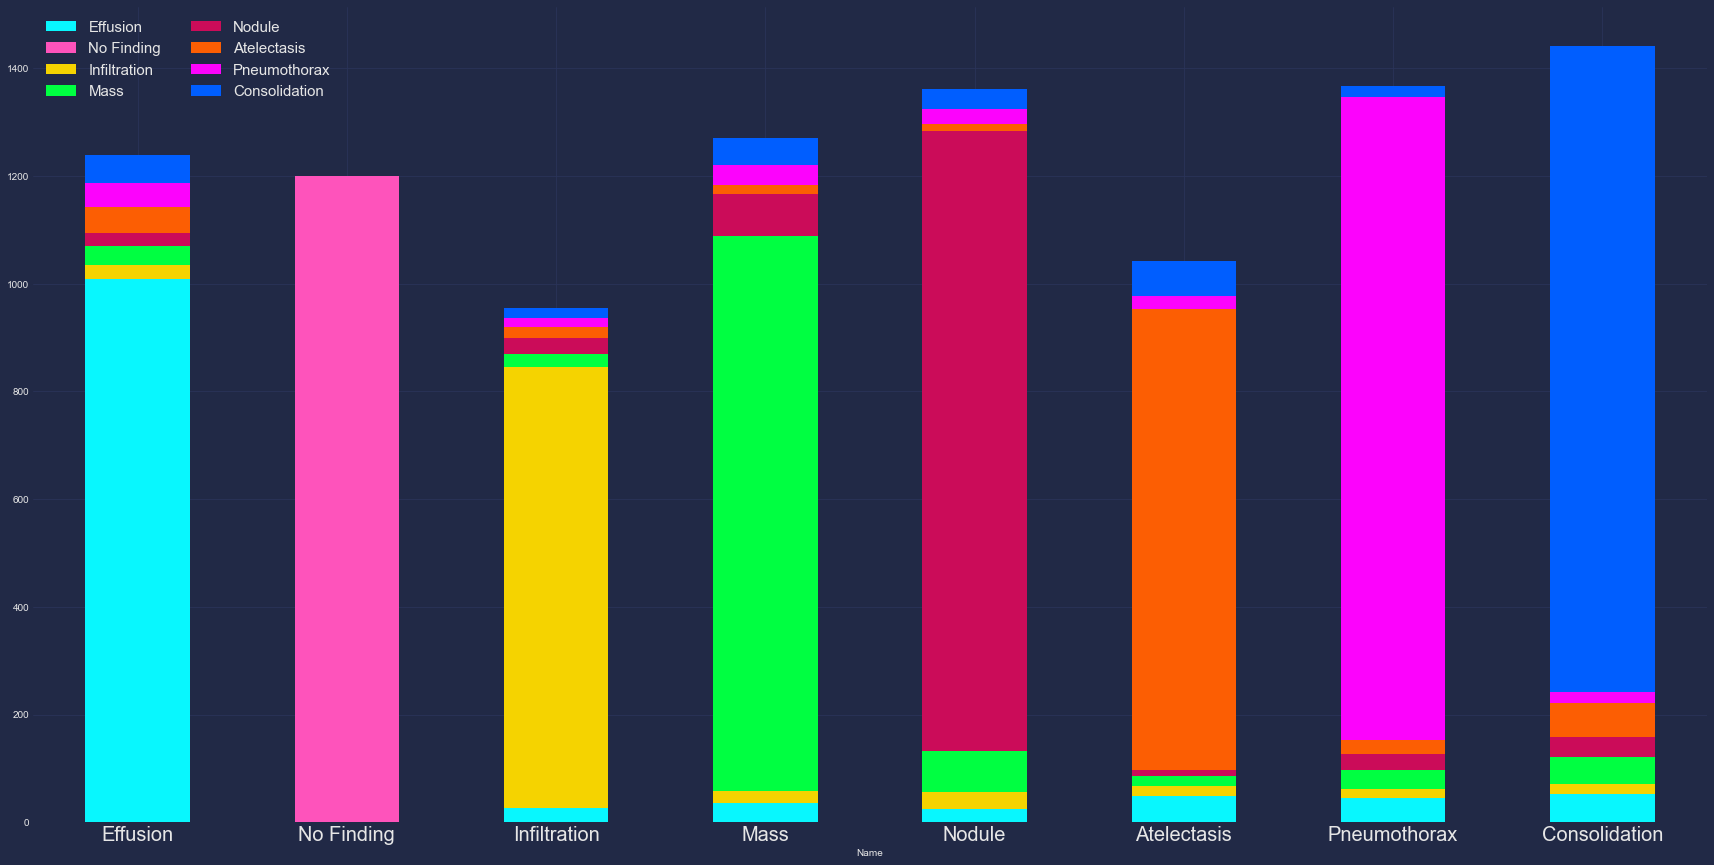

In [19]:
plt.rcParams["figure.figsize"] = (30,15)
dependencias.set_index("Name", inplace=True)
ax = dependencias.plot.bar(stacked=True, color=colors)
ax.legend(loc=2, prop={'size': 15}, ncol=2, shadow = True)
ax.tick_params(axis="x", labelrotation=0, labelsize=20)

Podemos obervar lo siguiente:  
Encontramos que todas las enfermedades tienen coincidencias con todas.
**Effusion:** destacan ligeramente sus coincidencias con **Consolidation** y **Pneumotorax**.  
**No finding:** debido a que es el caso de una persona sin enfermedades, no tiene coincidencias con ninguna de las otras columnas. Esto nos ha servido para verificar que los datos están bien.  
**Infiltration:** nada destacable.  
**Mass:** muchas coincidencias con **Nodule**.  
**Nodule:** muchas coincidencias con **Mass**.  
**Atelectasis:** gran número de casos compartidos con **Effusion** y **Consolidation**.  
**Pneumotorax:** coincidencias con **Effusion**.  
**Consolidation:** muchas coincidencias con **Effusion**, **Mass** y **Atelectasis**.  

Una vez realizado el balance de los datos, debemos procesar las imágenes para poder trabajar con ellas, guardándolas en nuestro proyecto como arrays para que la red neuronal las pueda procesar.

In [20]:
# Definimos las funciones que preprocesarán las imágenes
def preprocessImage(route: str, file: str): # Esta funcion realiza el preprocesamiento de cada imagen
    image = sima.transform.pyramid_reduce(sima.io.imread(route), downscale = DOWNSCALE)
    image = sima.util.img_as_ubyte(sima.exposure.rescale_intensity(image, (-1, 1)))
    sima.io.imsave(os.path.join(PREPROCESSED_IMAGES_PATH, file), image)
    
def preprocessData(): # Esto recorre el árbol de carpetas solo si no han sido preprocesadas ya las imágenes
    if not os.path.isdir(PREPROCESSED_IMAGES_PATH):
        os.mkdir(PREPROCESSED_IMAGES_PATH)
        for i in os.listdir(IMAGES_PATH):
            for file in os.listdir(os.path.join(IMAGES_PATH, i, "images")): # 'images' es la subcarpeta de cada 'file'
                myPath = os.path.join(IMAGES_PATH, i, "images", file)
                if os.path.isfile(myPath):
                    preprocessImage(myPath, file)
                    
def imgToArray(index: pd.Series): # Esta función guarda como array las imágenes
    aux = [PREPROCESSED_IMAGES_PATH + "/" + i for i in index]
    return [sima.io.imread(i) for i in aux]

Para evitar cargar con cada ejecución del notebook las imágenes las guardamos en una carpeta del proyecto gracias a una función de la librería de **numpy**.

Por último separamos nuestros datos en **train, test y validation** así como las labels del resto de los datos.

In [21]:
# Ejecutamos el preprocesamiento de las imágenes
preprocessData()
# Pasamos a dividir en conjuntos de test, train y validation
train_df, test_df = train_test_split(df, shuffle = True, random_state = 42, test_size = 0.2)
train_df, val_df = train_test_split(train_df, shuffle = True, random_state = 42, test_size = 0.2)
# Guardamos en local como arrays las imágenes para evitar cargas innecesarias
if os.path.isdir(IMAGE_NPY):
    train_imgs = np.load(IMAGE_NPY + '/train.npy')
    test_imgs = np.load(IMAGE_NPY + '/test.npy')
    val_imgs = np.load(IMAGE_NPY + '/val.npy')
else:
    train_imgs = imgToArray(train_df["Image Index"])
    test_imgs = imgToArray(test_df["Image Index"])
    val_imgs = imgToArray(val_df["Image Index"])
    
    os.mkdir(IMAGE_NPY)
    
    np.save(IMAGE_NPY + '/train.npy', train_imgs)
    np.save(IMAGE_NPY + '/test.npy', test_imgs)
    np.save(IMAGE_NPY + '/val.npy', val_imgs)
    
# Eliminamos el Image Index de los conjuntos
test_df.drop(["Image Index"], axis = 1, inplace = True)
val_df.drop(["Image Index"], axis = 1, inplace = True)
train_df.drop(["Image Index"], axis = 1, inplace = True)
# Separamos en x e y
x_train = train_df.iloc[:, :3]
y_train = train_df.iloc[:, 3:]


x_test = test_df.iloc[:, :2]
y_test = test_df.iloc[:, 3:]


x_val = val_df.iloc[:, :2]
y_val = val_df.iloc[:, 3:]

In [22]:
x_train

,Patient Age,Patient Gender,View Position
848,79,M,AP
2451,50,M,PA
5718,77,M,PA
1982,40,M,PA
6416,38,M,AP
...,...,...,...
2359,48,M,PA
280,53,F,PA
4637,56,M,AP
5236,48,M,AP


In [23]:
y_train

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
848,1,0,0,0,0,0,0,0
2451,0,0,0,0,1,0,0,0
5718,0,0,0,0,0,1,0,0
1982,0,0,0,1,1,0,0,0
6416,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2359,0,0,1,0,0,0,0,0
280,0,0,0,0,1,0,0,0
4637,0,0,0,0,0,0,0,1
5236,0,0,1,0,0,0,0,0


## Entrenamiento

Esto será util como callback para algunos de los modelos ya que ploteará como gráfica los resultados que se vayan obteniendo en tiempo real.

In [24]:
%matplotlib inline
class MyCallback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        plt.rcParams["figure.figsize"] = (30,10)
        fig, ax = plt.subplots(1, 2)
        fig.suptitle(f"epoch: {epoch}, {logs}", fontsize=20)
        history = list(logs.keys())
        for key in history:
            if key not in self.valores:
                self.valores[key] = []
            self.valores[key].append(logs[key])
            col = 0
            if key.startswith("val_"):
                col = 1
            if "loss" in key:
                a = ax[col].twinx()
            else:
                a = ax[col]
                a.set_ylim((0,1))
            a.plot(self.valores[key], label = key, c = colors[2 if "loss" in key else 3])
            maximum = np.argmax(self.valores[key])
            a.plot(maximum, self.valores[key][maximum], "o", color = colors[7])
            minimum = np.argmin(self.valores[key])
            a.plot(minimum, self.valores[key][minimum], "o", color = colors[4])
            a.text(minimum, self.valores[key][minimum], round(self.valores[key][minimum], 2))
            a.text(maximum, self.valores[key][maximum], round(self.valores[key][maximum], 2))
            a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})
        plt.show()
        display.clear_output(wait = True)
        
    def __init__(self):
        self.valores = {}
        
    def on_train_end(self, logs = None):
        print(f"Finished: {logs}")

### Primer modelo

En este primer modelo buscamos realizar una arquitectura sencilla. Usaremos la función **Softmax** como función de activación de la capa de salida de nuestra red, esto hará que se nos devuelva un número entre 0 y 1 para cada columna de salida mostrando la probabilidad de que esa imagen tenga la enfermedad correspondiente. Como función de pérdida a la hora de compilar nuestro modelo usaremos **Categorical Crossentropy** ya que es la que se usa típicamente para aquellos casos en los que se tienen las labels del dataset en el formato One-Hot.

In [39]:
model = keras.models.Sequential([
    keras.layers.Conv2D(124, 7, activation="relu", padding="same",
                        input_shape=[128, 128, 1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1337)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=628318)),
    keras.layers.Dropout(0.2, seed=14),
    keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13)),
    keras.layers.Dense(8, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=711))
])

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

history = model.fit(
    np.expand_dims(train_imgs, axis = 3),
    y_train,
    epochs=15,
    validation_data=(np.expand_dims(val_imgs, axis = 3), y_val),
    batch_size=64
)

Epoch 1/15
78/78 [==============================] - 10s 117ms/step - loss: 23.6239 - accuracy: 0.1359 - val_loss: 2.2965 - val_accuracy: 0.1372
Epoch 2/15
78/78 [==============================] - 8s 105ms/step - loss: 2.2491 - accuracy: 0.1646 - val_loss: 2.2743 - val_accuracy: 0.1525
Epoch 3/15
78/78 [==============================] - 8s 106ms/step - loss: 2.2475 - accuracy: 0.1529 - val_loss: 2.2721 - val_accuracy: 0.1517
Epoch 4/15
78/78 [==============================] - 8s 106ms/step - loss: 2.2468 - accuracy: 0.1601 - val_loss: 2.2775 - val_accuracy: 0.1356
Epoch 5/15
78/78 [==============================] - 8s 107ms/step - loss: 2.2407 - accuracy: 0.1597 - val_loss: 2.2820 - val_accuracy: 0.1493
Epoch 6/15
78/78 [==============================] - 9s 112ms/step - loss: 3.0669 - accuracy: 0.1662 - val_loss: 2.3063 - val_accuracy: 0.1413
Epoch 7/15
78/78 [==============================] - 9s 112ms/step - loss: 2.2400 - accuracy: 0.1575 - val_loss: 2.3094 - val_accuracy: 0.1316
Epoc

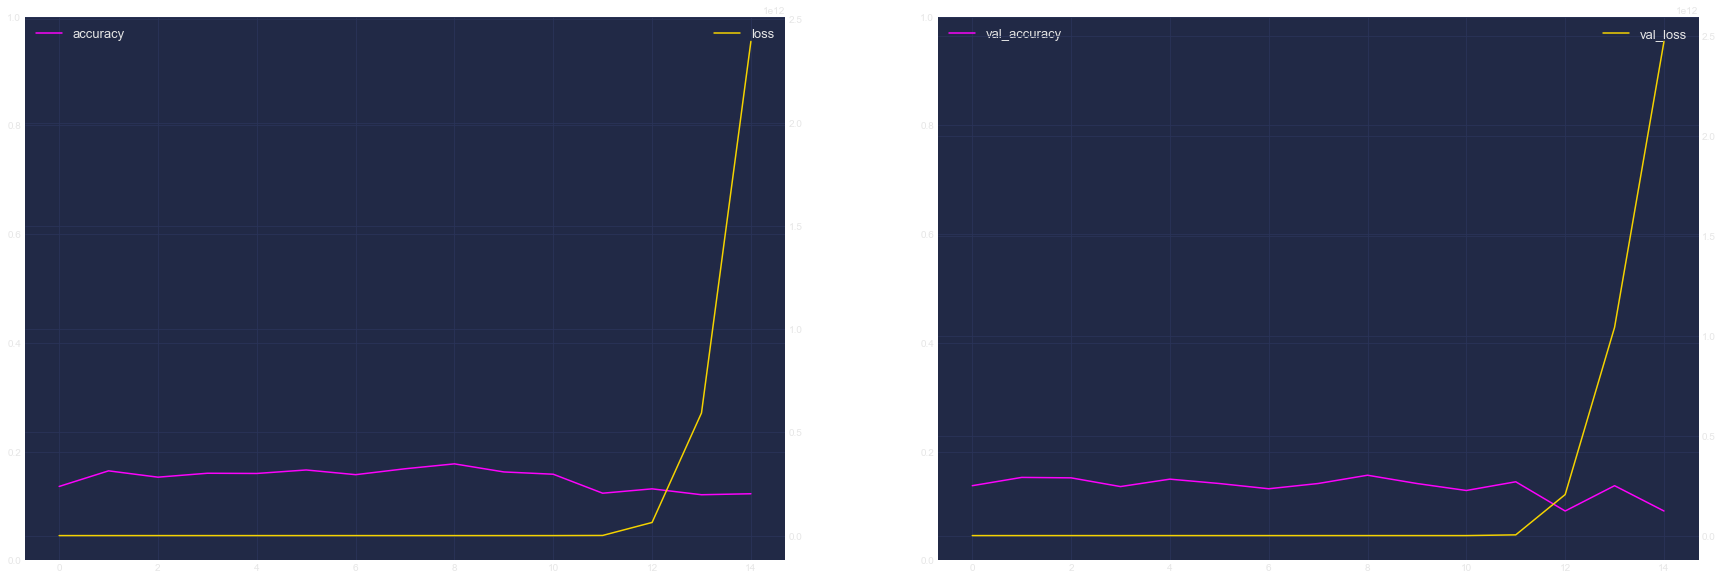

In [52]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [53]:
test_loss = model.evaluate(np.expand_dims(test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 2s - loss: 2451666370560.0000 - accuracy: 0.0950 - 2s/epoch - 32ms/step


In [54]:
pred = model.predict(np.expand_dims(test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [55]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


Una vez realizado el entrenamiento y probado a hacer predicciones hemos podido observar que la red no funciona de la forma en que debería, no es capaz de aprender y marca siempre como enfermedad **Atelectasis**.  
El loss comienza bajando y termina alcanzando números muy elevados, esto unido a lo anterior nos indica la red no se ajusta bien al problema que intentamos resolver.

Tras una búsqueda de cual era el problema que estaba ocurriendo, hemos aprendido que existen tres tipos de problemas de clasificación a los que nos podemos enfrentar:  
- En primer lugar tenemos los problemas de **Clasificación Binaria**, estos son aquellos que pretenden clasificar entre dos opciones (Ej: Saber si una imagen de de gato o de perro). Estos casos se deben enfrentar con el uso de **Binary Crossentropy**.
- En segundo lugar tenemos la **Clasificación Multiclase**, estos son aquellos problemas que tienen más de dos label como posible solución y estas labels son mutuamente excluyentes. Esto quiere decir que si un elemento pertenece a una clase no podrá pertenecer a otra. En este caso de debe usar **Categorical Crossentropy**. En mi caso yo había usado esto pensando que era lo que necesitaba cuando en mi caso las clases no son excluyentes ya que un paciente puede tener más de una enfermedad.
- Por último tenemos **Clasificación Multietiqueta**, estos son los problemas que tienen más de dos labels y éstas no son mutuamente excluyentes. Para estos casos se debe usar **Binary Crossentropy**. Este es nuestro caso y por ello en el siguiente modelo es lo que usaremos.

### Segundo modelo

En este modelo vamos a realizar ajustes a la red, entre ellos los ya mencionados al final del anterior.

In [57]:
model = keras.models.Sequential([
    keras.layers.Conv2D(124, 7, activation="relu", padding="same",
                        input_shape=[128, 128, 1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 5, activation="relu", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.Conv2D(256, (5, 3), activation="relu", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 5, activation="relu", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1337)),
    keras.layers.Conv2D(512, (3, 1), activation="relu", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=14)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=628318)),
    keras.layers.Dropout(0.5, seed=711),
    keras.layers.Dense(8, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13))
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm=1), metrics=["categorical_accuracy"])

early_stopping_acc = tf.keras.callbacks.EarlyStopping(monitor = "categorical_accuracy", patience = 3)
plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(train_imgs, axis = 3),
    y_train,
    epochs=50,
    validation_data=(np.expand_dims(val_imgs, axis = 3), y_val),
    batch_size=128,
    callbacks = [
        early_stopping_acc
    ]
)

Epoch 1/50
39/39 [==============================] - 25s 625ms/step - loss: 6.8890 - categorical_accuracy: 0.1357 - val_loss: 0.4039 - val_categorical_accuracy: 0.1485
Epoch 2/50
39/39 [==============================] - 24s 626ms/step - loss: 0.4174 - categorical_accuracy: 0.1379 - val_loss: 0.3981 - val_categorical_accuracy: 0.1613
Epoch 3/50
39/39 [==============================] - 24s 618ms/step - loss: 0.4119 - categorical_accuracy: 0.1553 - val_loss: 0.3996 - val_categorical_accuracy: 0.1533
Epoch 4/50
39/39 [==============================] - 24s 620ms/step - loss: 0.4083 - categorical_accuracy: 0.1622 - val_loss: 0.4001 - val_categorical_accuracy: 0.1758
Epoch 5/50
39/39 [==============================] - 24s 624ms/step - loss: 0.4030 - categorical_accuracy: 0.1722 - val_loss: 0.3954 - val_categorical_accuracy: 0.1726
Epoch 6/50
39/39 [==============================] - 24s 616ms/step - loss: 0.4003 - categorical_accuracy: 0.1846 - val_loss: 0.3947 - val_categorical_accuracy: 0.201

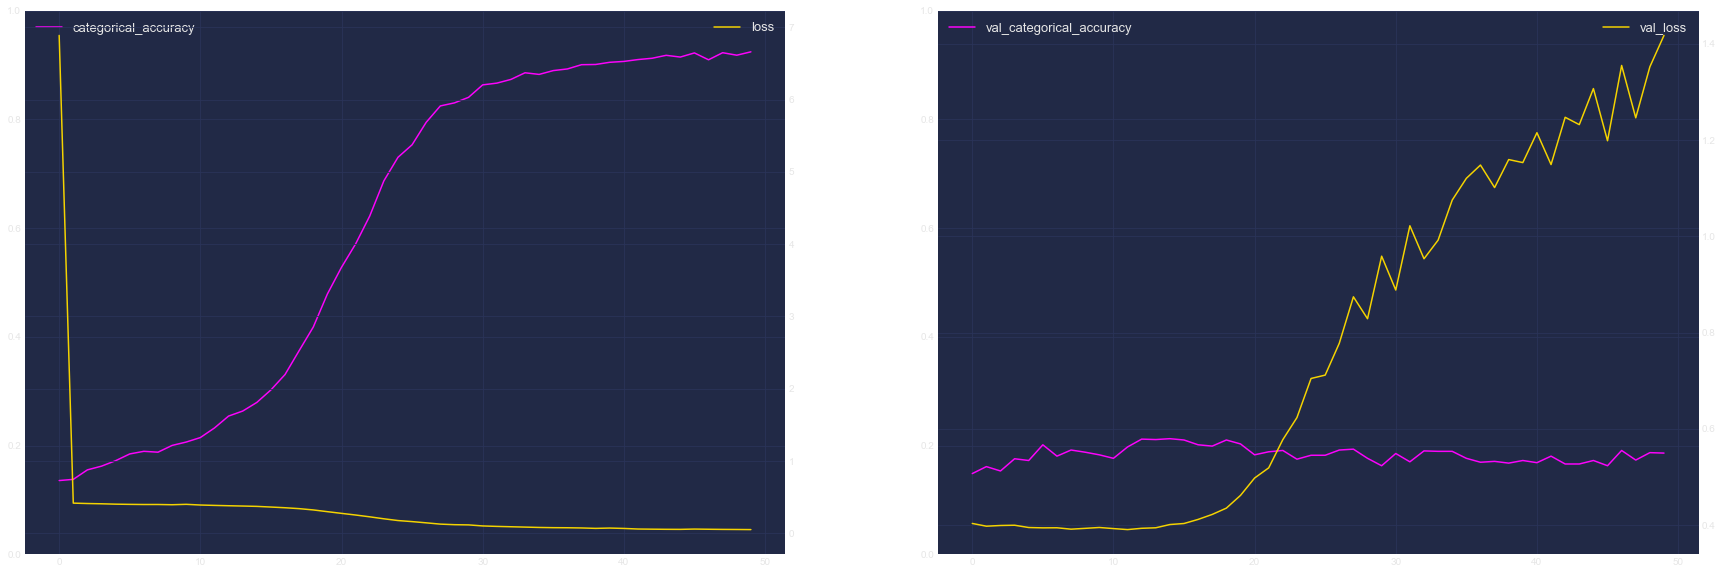

In [58]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [59]:
test_loss = model.evaluate(np.expand_dims(test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 3s - loss: 1.3284 - categorical_accuracy: 0.1958 - 3s/epoch - 65ms/step


In [60]:
pred = model.predict(np.expand_dims(test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.000076,0.020735,0.000044,0.000020,0.000048,0.000561,0.000605,0.451051
1,0.000000,0.453228,0.000249,0.063012,0.000008,0.000024,0.000006,0.000062
2,0.000267,0.000002,0.000511,0.000462,0.000001,0.000032,0.597554,0.512799
3,0.081628,0.000021,0.056692,0.000001,0.000029,0.004164,0.002310,0.044556
4,0.071702,0.020694,0.127388,0.000453,0.000448,0.000029,0.006965,0.041792
5,0.384332,0.106858,0.026452,0.022963,0.233563,0.003091,0.003728,0.072184
6,0.010169,0.218670,0.001409,0.000438,0.020360,0.004852,0.028878,0.005825
7,0.000000,0.000802,0.000003,0.000000,0.000000,0.000000,0.044362,0.000032
8,0.000049,0.010940,0.000001,0.000517,0.146626,0.000014,0.000262,0.000355
9,0.000099,0.083545,0.000205,0.000671,0.000006,0.001120,0.002253,0.050662


In [61]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


Como se puede observar claramente la red está haciendo overfitting de los datos, comparado con el anterior modelo, este por lo menos estamos viendo que aprende y no dice siempre lo mismo. Lo malo es que se acostumbra demasiado a los datos de train y por ello tenemos que conseguir que no lo haga.  

Vamos a realizar predicciones sobre el conjunto de entrenamiento para verificar el overfitting de los datos:

In [62]:
pred = model.predict(np.expand_dims(train_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_grthan, n=0.8, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.884707,0.000315,0.000004,0.000094,0.000001,0.000000,0.000001,0.000042
1,0.000000,0.000000,0.000000,0.000000,0.999928,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.999967,0.000000,0.000000
3,0.000005,0.000000,0.000000,0.907258,0.920738,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.999603,0.000000,0.000000,0.000000,0.000000
5,0.000003,0.000000,0.000000,0.000000,0.000000,0.991926,0.000003,0.001568
6,0.000000,0.000000,0.000000,0.000000,0.999595,0.000000,0.000000,0.000000
7,0.000000,0.000204,0.000000,0.000000,0.985350,0.000000,0.000000,0.000000
8,0.000000,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997582


In [63]:
y_train.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
848,1,0,0,0,0,0,0,0
2451,0,0,0,0,1,0,0,0
5718,0,0,0,0,0,1,0,0
1982,0,0,0,1,1,0,0,0
6416,0,0,0,1,0,0,0,0
5810,0,0,0,0,0,1,0,0
674,0,0,0,0,1,0,0,0
6402,0,0,0,0,1,0,0,0
3498,0,1,0,0,0,0,0,0
5052,0,0,0,0,0,0,0,1


Como ya habíamos observado, el modelo está overfiteado.

### Tercer modelo

En este tercer modelo vamos a reducir en gran medida la arquitectura para ver si conseguimos de no siga haciendo overfitting.

Tras muchas pruebas hemos observado que esta es una de las redes más pequeñas que podemos construir y que siga aprendiendo, si se modifica un poco dejaba de aprender por completo. Por lo tanto en los próximos modelos vamos a intentar mejorarlo en base a lo aprendido.

In [65]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 4, activation = "relu", padding = "same",
                        input_shape = [128, 128, 1], kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 42)),
    keras.layers.Conv2D(32, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation = "relu", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=628318)),
    keras.layers.Dropout(0.5, seed = 711),
    keras.layers.Dense(8, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=13))
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.00001), metrics=["categorical_accuracy"])

plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(train_imgs, axis = 3),
    y_train,
    epochs = 300,
    validation_data = (np.expand_dims(val_imgs, axis = 3), y_val),
    batch_size = 32,
    callbacks = [
        plot_callback
    ],
    verbose = 0
)

Finished: {'loss': 0.32558780908584595, 'categorical_accuracy': 0.4232390224933624, 'val_loss': 0.4068656861782074, 'val_categorical_accuracy': 0.227126806974411}


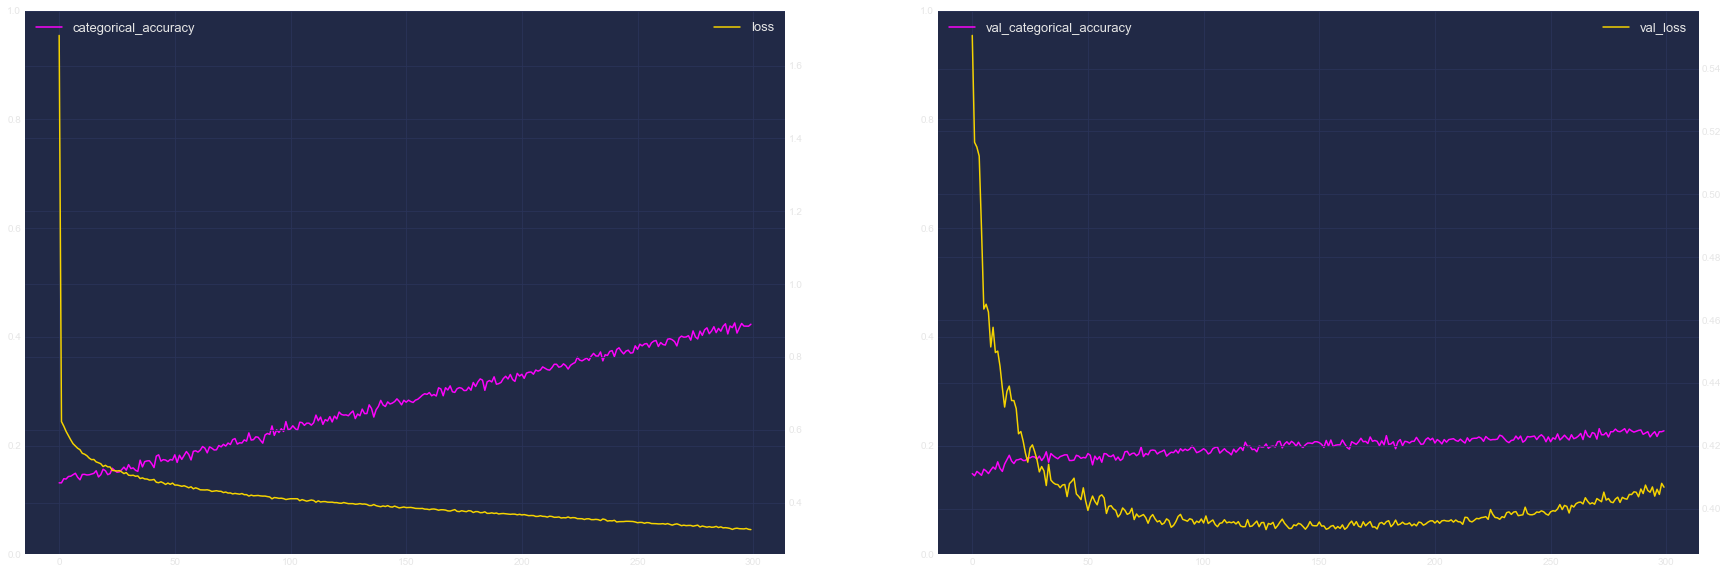

In [66]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [67]:
test_loss = model.evaluate(np.expand_dims(test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 0s - loss: 0.4012 - categorical_accuracy: 0.2336 - 356ms/epoch - 7ms/step


In [68]:
pred = model.predict(np.expand_dims(test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.058065,0.116887,0.064647,0.146984,0.116714,0.026952,0.235720,0.088800
1,0.028179,0.319487,0.218822,0.114896,0.144442,0.138702,0.061152,0.024869
2,0.539851,0.079073,0.347706,0.062611,0.068041,0.091540,0.167162,0.141611
3,0.091908,0.029307,0.176156,0.318543,0.056252,0.166858,0.133306,0.467494
4,0.112603,0.030165,0.087490,0.078502,0.033538,0.097385,0.058349,0.552236
5,0.147288,0.048032,0.089219,0.109367,0.129537,0.060984,0.150633,0.183809
6,0.225022,0.232224,0.129638,0.086011,0.087345,0.178039,0.103524,0.127449
7,0.037150,0.089743,0.053335,0.213568,0.104152,0.018393,0.124718,0.103469
8,0.092476,0.349164,0.078923,0.104511,0.399493,0.052521,0.113064,0.070414
9,0.136285,0.131224,0.076840,0.068883,0.028666,0.322836,0.031004,0.374094


In [69]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


A pesar de haber reducido en gran medida la red observamos que sigue habiendo overfit, por lo tanto el siguiente paso es probar algunos de los métodos más utilizados para evitar esto.

### Cuarto modelo

Probamos algunos de los métodos usados para evitar overfitting

In [48]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation = "relu", padding = "same", input_shape = [128, 128, 1], kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.35),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 42)),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 1337)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 314)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 14)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 62831)),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation = "relu", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=1337), activity_regularizer = "l2", kernel_regularizer = "l2")
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0001), metrics=["categorical_accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_categorical_accuracy", patience = 15)
plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(train_imgs, axis = 3),
    y_train,
    epochs = 300,
    validation_data = (np.expand_dims(val_imgs, axis = 3), y_val),
    batch_size = 32,
    callbacks = [
        plot_callback
    ],
    verbose = 0
)

Finished: {'loss': 0.3365492820739746, 'categorical_accuracy': 0.37989163398742676, 'val_loss': 0.40579327940940857, 'val_categorical_accuracy': 0.2287319451570511}


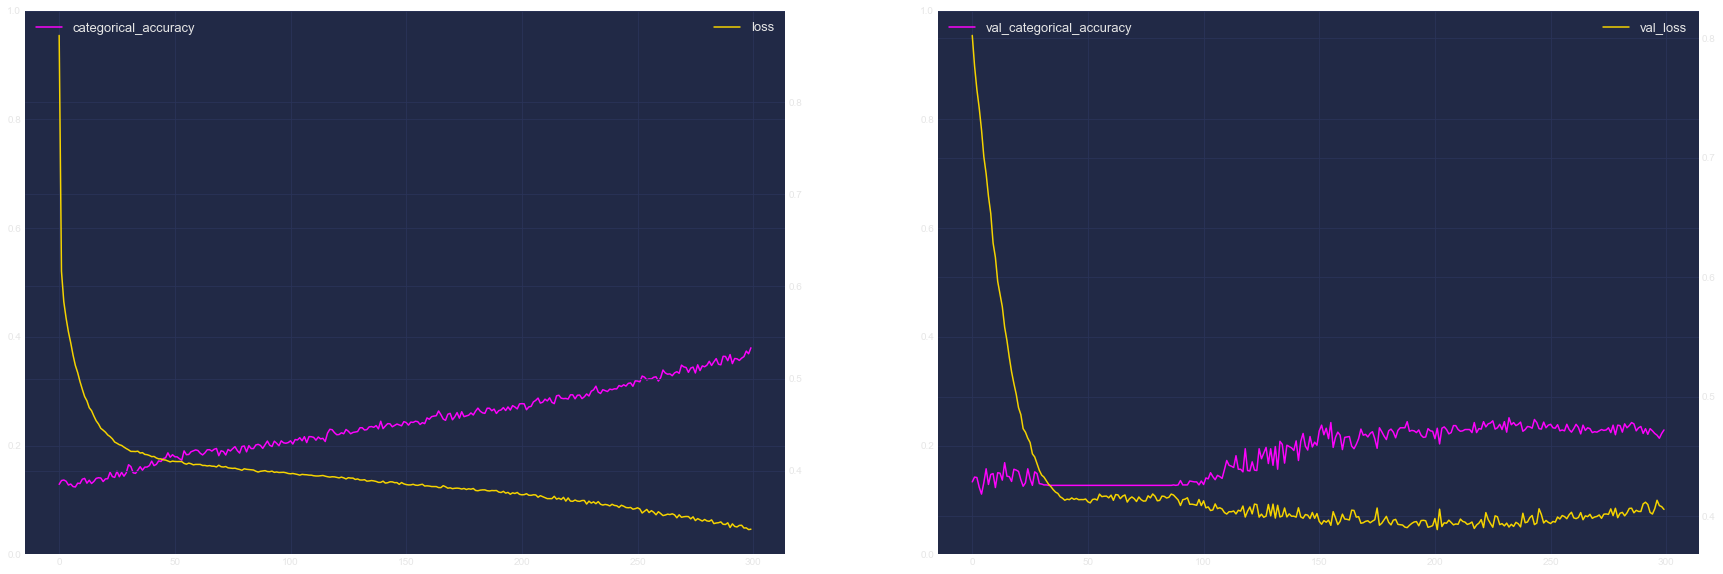

In [49]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [50]:
test_loss = model.evaluate(np.expand_dims(test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 0s - loss: 0.4038 - categorical_accuracy: 0.2259 - 273ms/epoch - 6ms/step


In [51]:
pred = model.predict(np.expand_dims(test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.005638,0.184854,0.035714,0.105974,0.125354,0.020256,0.430002,0.078347
1,0.108882,0.240351,0.177691,0.140492,0.171089,0.160378,0.048261,0.167412
2,0.374230,0.022748,0.089964,0.065609,0.014369,0.112492,0.061184,0.374656
3,0.140005,0.252554,0.162393,0.055711,0.041059,0.174189,0.044898,0.285509
4,0.077577,0.062867,0.270122,0.011481,0.001505,0.058403,0.026931,0.586414
5,0.157029,0.144365,0.047435,0.113306,0.117249,0.285648,0.223547,0.221542
6,0.185039,0.037336,0.155731,0.009044,0.004896,0.139257,0.086449,0.297765
7,0.067890,0.048511,0.065581,0.179625,0.107828,0.033997,0.244136,0.230776
8,0.210548,0.193020,0.100047,0.089790,0.177783,0.139759,0.277429,0.071453
9,0.074180,0.123262,0.205379,0.011667,0.002589,0.095564,0.034839,0.355904


In [52]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


### Quinto Modelo

Hemos observado que solo catalogaba como correctas aquellas que acertaba al 100% debido al categorical_accuracy, por ello vamos a repetir la prueba anterior pero esta vez con binary_accuracy que valora si se aciertan tanto las enfermedades detectadas como si se acierta el decir que una de ellas no se encuentra en la imagen.

In [29]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation = "relu", padding = "same", input_shape = [128, 128, 1], kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.35),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 42)),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 1337)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 314)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 14)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 62831)),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation = "relu", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=1337), activity_regularizer = "l2", kernel_regularizer = "l2")
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0001), metrics=["binary_accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_categorical_accuracy", patience = 15)
plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(train_imgs, axis = 3),
    y_train,
    epochs = 300,
    validation_data = (np.expand_dims(val_imgs, axis = 3), y_val),
    batch_size = 32,
    callbacks = [
        plot_callback
    ],
    verbose = 0
)

Finished: {'loss': 0.377280592918396, 'binary_accuracy': 0.8648404479026794, 'val_loss': 0.41186651587486267, 'val_binary_accuracy': 0.8613563179969788}


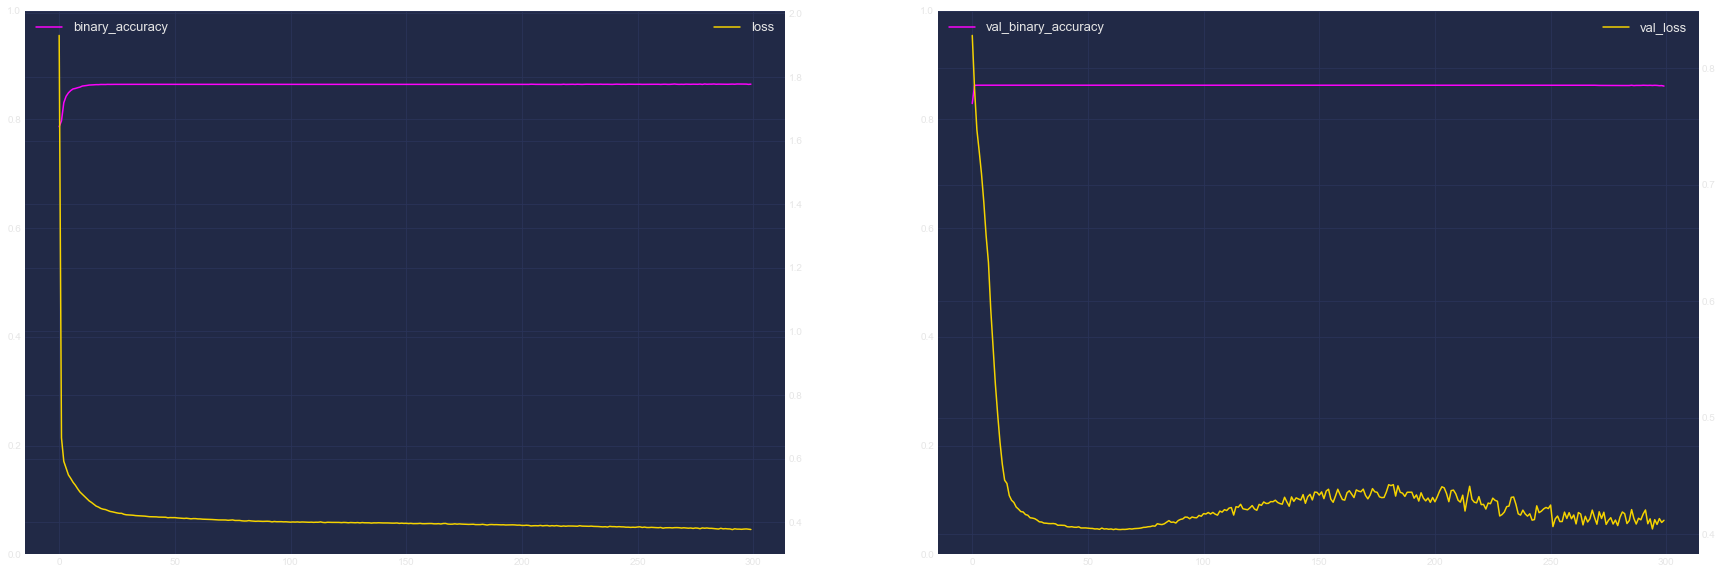

In [30]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [31]:
test_loss = model.evaluate(np.expand_dims(test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 0s - loss: 0.4082 - binary_accuracy: 0.8625 - 359ms/epoch - 7ms/step


In [32]:
pred = model.predict(np.expand_dims(test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.084599,0.114040,0.135480,0.073974,0.044005,0.056150,0.198073,0.272486
1,0.101611,0.200611,0.159831,0.150572,0.149355,0.103568,0.192303,0.169464
2,0.232460,0.098562,0.136542,0.065997,0.062165,0.157846,0.181561,0.258472
3,0.144071,0.045158,0.189488,0.020129,0.006885,0.084892,0.064111,0.535514
4,0.155103,0.042186,0.163633,0.021211,0.007118,0.074802,0.070545,0.533873
5,0.262624,0.110359,0.086049,0.076824,0.101457,0.183690,0.141773,0.201211
6,0.187509,0.067328,0.160579,0.033177,0.019736,0.120713,0.088961,0.422911
7,0.078721,0.179322,0.135808,0.137824,0.110287,0.071328,0.218868,0.162524
8,0.296437,0.112628,0.107160,0.101992,0.142922,0.166494,0.181860,0.153223
9,0.138731,0.048499,0.180002,0.022817,0.008408,0.080870,0.070955,0.513552


In [33]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


Observando los resultados y comparando las predicciones se puede decir que el accuracy es muy bueno debido a que da muchos falsos, es decir, la red dice a la mayoria que no tiene esa enfermedad y debido a que esta acertando tecnicamente saca un buen accuracy pero luego a la hora de decir la enfermedad que si tiene rara vez acierta por lo tanto la red sigue sin interpretar bien los datos.

## Modificaciones en el preprocesamiento de las imágenes

Debido a que los resultados obtenidos en las pruebas anteriores no han sido prometedores vamos a intentar modificar un poco el preprocesamiento de las imágenes de forma que podamos llegar a ayudar a la red a aprender mejor.  

Para ello vamos a crear una nueva función que normalizará las imágenes. Esta normalizacion consiste en extraer la media y la desviación de las imágenes y COMPLETAR

In [25]:
def normalize():
    mean = np.mean(np.concatenate((test_imgs, train_imgs, val_imgs), axis = 0))
    std = np.std(np.concatenate((test_imgs, train_imgs, val_imgs), axis = 0))
    new_train_imgs = (train_imgs - mean) / std
    new_test_imgs = (test_imgs - mean) / std
    new_val_imgs = (val_imgs - mean) / std
    return new_train_imgs, new_test_imgs, new_val_imgs

new_train_imgs, new_test_imgs, new_val_imgs = normalize()

Observamos cómo han quedado las imágenes

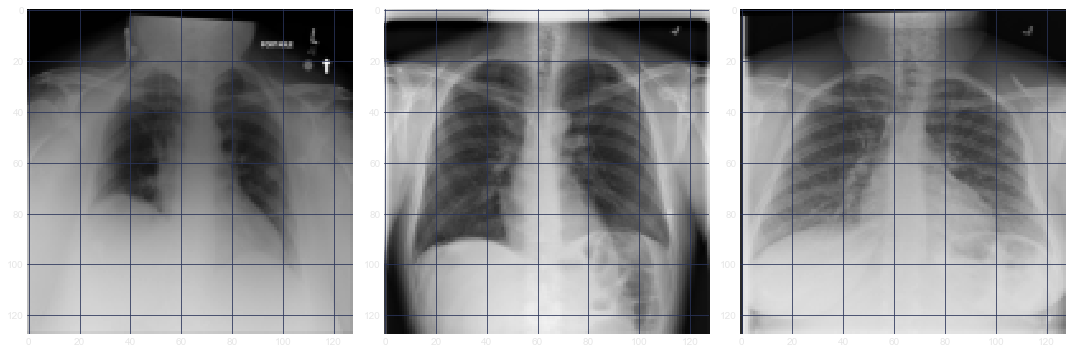

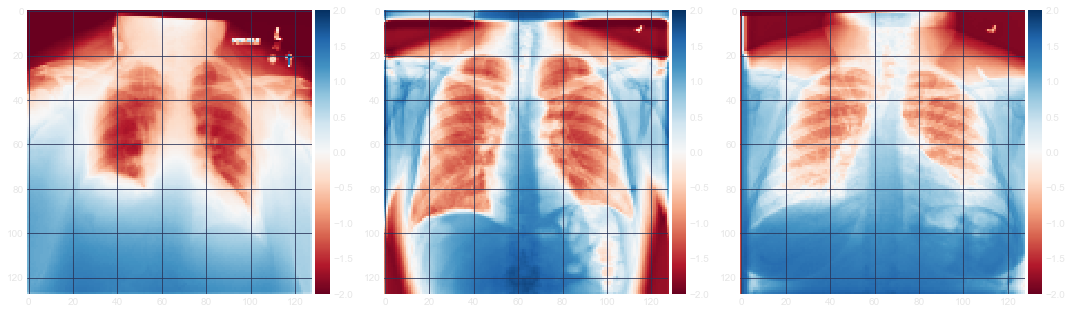

In [26]:
plt.rcParams["figure.figsize"] = (15,15)
plt.subplot(2, 3, 1)
sima.io.imshow(val_imgs[0])
plt.subplot(2, 3, 2)
sima.io.imshow(val_imgs[1])
plt.subplot(2, 3, 3)
sima.io.imshow(val_imgs[2])
plt.show()
plt.subplot(2, 3, 1)
sima.io.imshow(new_val_imgs[0])
plt.subplot(2, 3, 2)
sima.io.imshow(new_val_imgs[1])
plt.subplot(2, 3, 3)
sima.io.imshow(new_val_imgs[2])
plt.show()

## Vuelta al entrenamiento

### Quinto Modelo con nuevas imágenes

In [27]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation = "relu", padding = "same", input_shape = [128, 128, 1], kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.35),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 42)),
    keras.layers.Conv2D(16, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 1337)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 314)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 14)),
    keras.layers.Conv2D(16, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 62831)),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation = "relu", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=1337), activity_regularizer = "l2", kernel_regularizer = "l2")
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0001), metrics=["binary_accuracy"])

plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(new_train_imgs, axis = 3),
    y_train,
    epochs = 100,
    validation_data = (np.expand_dims(new_val_imgs, axis = 3), y_val),
    batch_size = 128,
    callbacks = [
        plot_callback
    ],
    verbose = 0
)

Finished: {'loss': 0.4010244309902191, 'binary_accuracy': 0.864338755607605, 'val_loss': 0.40338197350502014, 'val_binary_accuracy': 0.86296147108078}


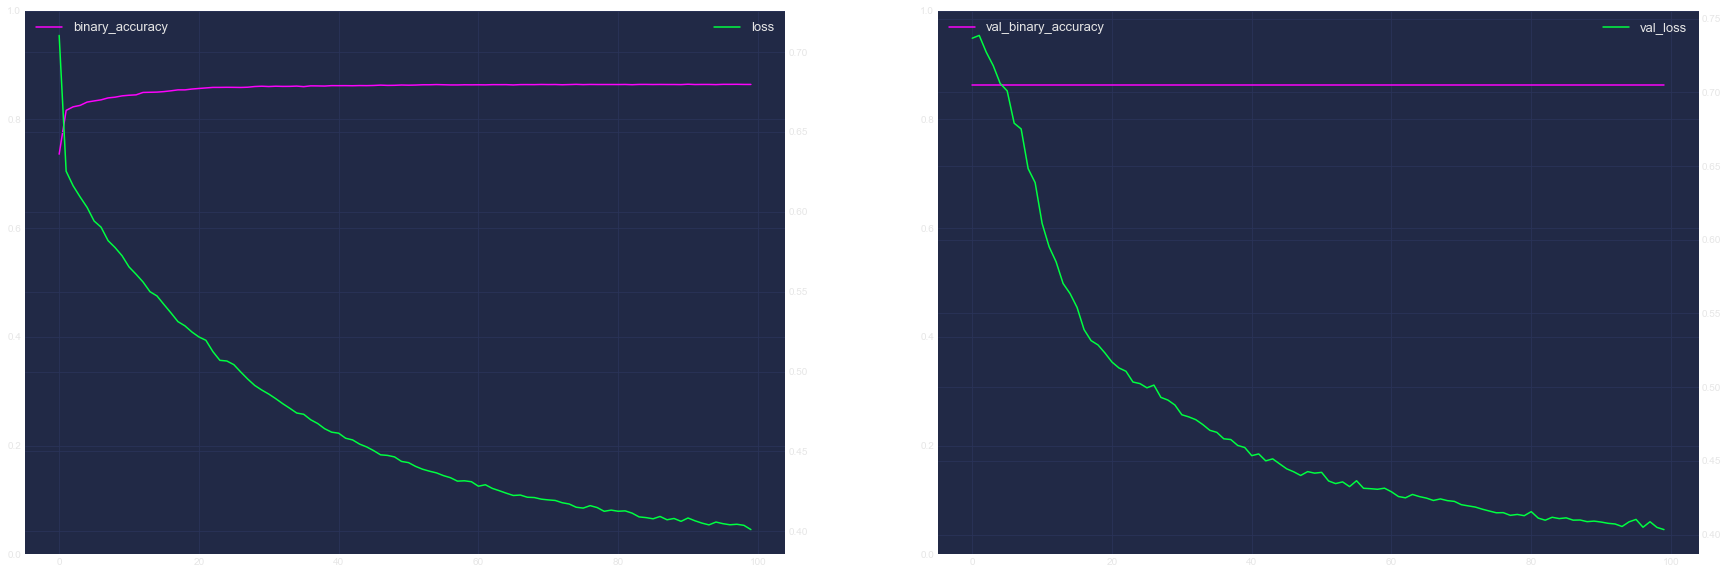

In [28]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[3 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [29]:
test_loss = model.evaluate(np.expand_dims(new_test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 0s - loss: 0.4009 - binary_accuracy: 0.8642 - 346ms/epoch - 7ms/step


In [30]:
pred = model.predict(np.expand_dims(new_test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.089928,0.222927,0.146515,0.160277,0.182070,0.114745,0.187255,0.169932
1,0.096289,0.254394,0.170263,0.199926,0.233998,0.100885,0.202567,0.140018
2,0.265538,0.129979,0.149315,0.141111,0.126688,0.220168,0.182425,0.234774
3,0.142528,0.154664,0.132668,0.098678,0.099166,0.159866,0.234373,0.196178
4,0.140802,0.131634,0.143910,0.090097,0.091396,0.122560,0.178774,0.337122
5,0.240039,0.169513,0.158618,0.165644,0.165980,0.201076,0.176511,0.233955
6,0.121649,0.179556,0.126231,0.107605,0.114805,0.170392,0.255420,0.139827
7,0.091939,0.224505,0.163155,0.164605,0.193352,0.078766,0.233965,0.164664
8,0.282919,0.144791,0.138961,0.163946,0.196571,0.230932,0.223379,0.167143
9,0.112149,0.159039,0.133100,0.106415,0.105902,0.144829,0.130468,0.278526


In [31]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


### Sexto Modelo con nuevas imágenes

In [32]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 5, activation = "relu", padding = "same", input_shape = [128, 128, 1], kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 13)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.35),
    keras.layers.Conv2D(64, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 42)),
    keras.layers.Conv2D(64, 4, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 1337)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 314)),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 16)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.55),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 14)),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 62831)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform(seed=1337), activity_regularizer = "l2", kernel_regularizer = "l2")
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0001), metrics=["binary_accuracy"])

plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(new_train_imgs, axis = 3),
    y_train,
    epochs = 100,
    validation_data = (np.expand_dims(new_val_imgs, axis = 3), y_val),
    batch_size = 128,
    callbacks = [
        plot_callback
    ],
    verbose = 0
)

Finished: {'loss': 0.09536921232938766, 'binary_accuracy': 0.9669125080108643, 'val_loss': 1.0306363105773926, 'val_binary_accuracy': 0.8428972959518433}


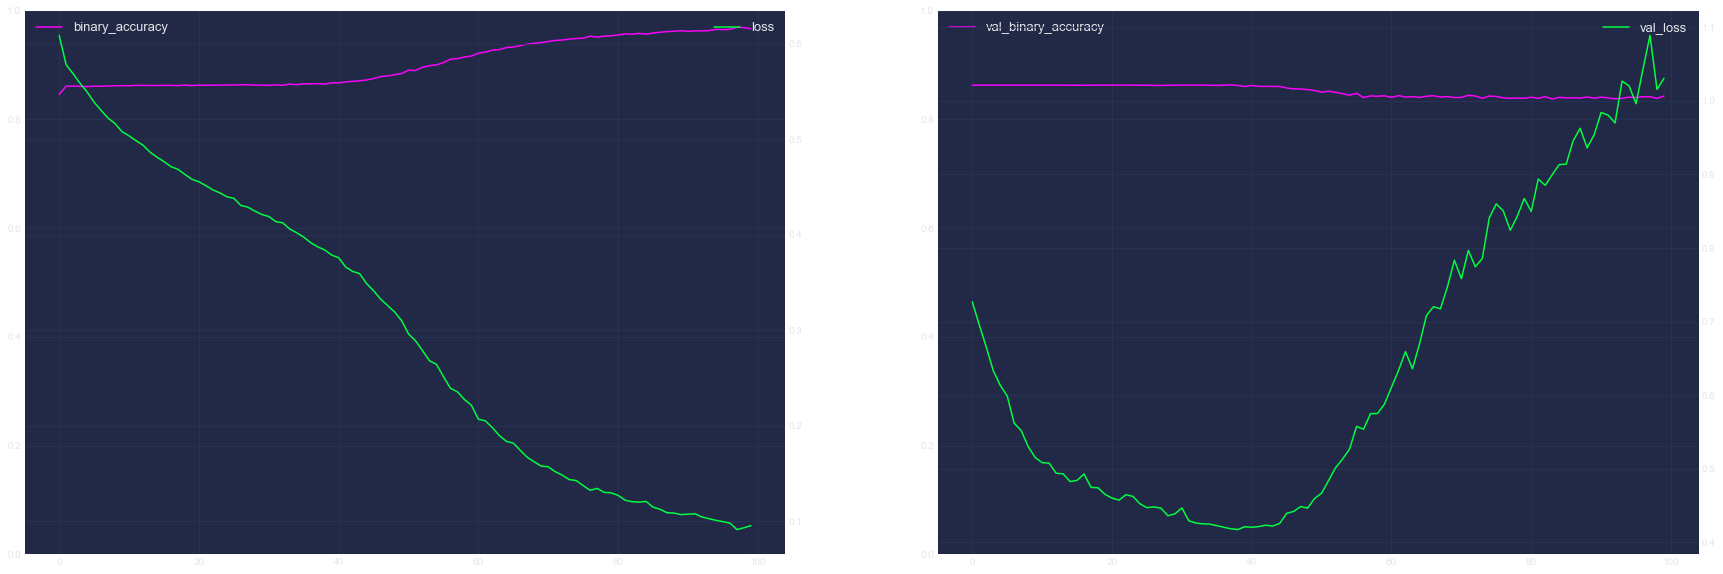

In [33]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[3 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [34]:
test_loss = model.evaluate(np.expand_dims(new_test_imgs, axis = 3),  y_test, verbose=2)

49/49 - 1s - loss: 0.9925 - binary_accuracy: 0.8432 - 843ms/epoch - 17ms/step


In [35]:
pred = model.predict(np.expand_dims(new_test_imgs, axis = 3))
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.000001,0.000000,0.000000,0.010649,0.000245,0.000002,0.101073,0.000000
1,0.000892,0.616882,0.035746,0.002515,0.094479,0.000619,0.003853,0.000564
2,0.147778,0.000012,0.000001,0.003775,0.000138,0.000016,0.035500,0.012140
3,0.002316,0.005292,0.014546,0.000006,0.000055,0.005165,0.623109,0.000012
4,0.081247,0.000039,0.005117,0.009066,0.000024,0.000902,0.001210,0.769340
5,0.005437,0.002621,0.000142,0.033655,0.075380,0.017049,0.035991,0.000420
6,0.000523,0.038872,0.001234,0.000405,0.000172,0.010057,0.037645,0.000004
7,0.000361,0.024972,0.014349,0.000330,0.001384,0.003608,0.270962,0.000131
8,0.770556,0.000008,0.000010,0.000308,0.000017,0.000001,0.037234,0.000024
9,0.023181,0.562683,0.034040,0.003204,0.008689,0.010309,0.054833,0.001101


In [36]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;border-color:white', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


## Nuevo enfoque

### Preprocesamiento

En este apartado vamos a modificar el enfoque y vamos a intentar diferenciar entre las imágenes que tienen enfermedad y las que no. Para ello en primer lugar vamos a volver a balancear las imágenes.

In [61]:
df_binary

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
3,00000002_000.png,81,M,PA,0,1,0,0,0,0,0,0
12,00000004_000.png,82,M,AP,0,0,0,1,1,0,0,0
13,00000005_000.png,69,F,PA,0,1,0,0,0,0,0,0
14,00000005_001.png,69,F,AP,0,1,0,0,0,0,0,0
15,00000005_002.png,69,F,AP,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,39,M,PA,0,1,0,0,0,0,0,0
112116,00030802_000.png,29,M,PA,0,1,0,0,0,0,0,0
112117,00030803_000.png,42,F,PA,0,1,0,0,0,0,0,0
112118,00030804_000.png,30,F,PA,0,1,0,0,0,0,0,0


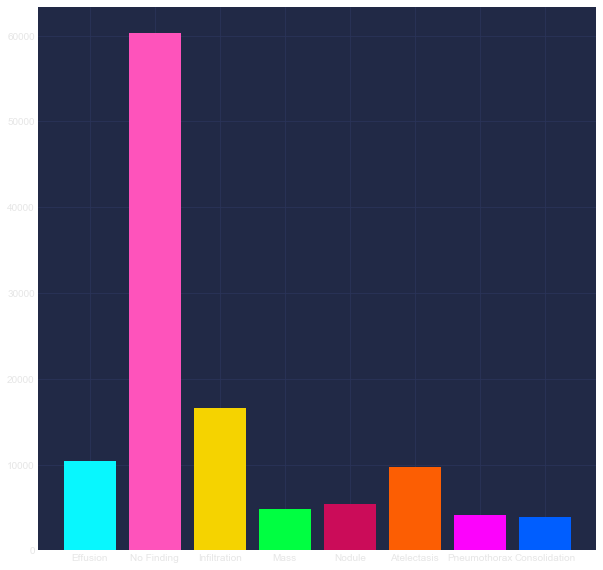

In [62]:
aux = {column : len([x for x in df_binary[column] if str(x)>"0"]) for column in df_binary.columns[4:]}
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(range(len(aux)), list(aux.values()), tick_label=list(aux.keys()), color = colors)
plt.show()

Vemos la suma de las enfermedades para bajar el número de **No Finding**.

In [63]:
df_binary[df_binary["No Finding"] != 1]

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
12,00000004_000.png,82,M,AP,0,0,0,1,1,0,0,0
19,00000005_006.png,70,F,PA,0,0,1,0,0,0,0,0
20,00000005_007.png,70,F,PA,1,0,1,0,0,0,0,0
25,00000008_002.png,73,F,PA,0,0,0,0,1,0,0,0
27,00000010_000.png,84,F,PA,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
112084,00030780_000.png,67,M,PA,0,0,0,0,0,1,0,0
112090,00030786_000.png,61,F,PA,1,0,0,0,0,0,0,0
112096,00030786_006.png,61,F,AP,0,0,0,0,0,0,0,1
112100,00030789_000.png,52,F,PA,0,0,1,0,0,0,0,0


In [64]:
df_binary = resizeSamples(df_binary, "No Finding", 39000)
df_binary

,Image Index,Patient Age,Patient Gender,View Position,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,00020513_023.png,24,F,AP,0,0,1,0,0,0,0,0
1,00030379_002.png,58,F,AP,0,0,1,0,0,1,0,0
2,00030689_001.png,35,F,AP,0,0,0,0,0,1,0,0
3,00009669_003.png,39,M,PA,1,0,1,1,0,1,0,0
4,00002524_029.png,54,M,PA,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
77662,00005695_000.png,20,F,AP,1,0,0,0,0,0,0,0
77663,00002524_030.png,55,M,PA,0,1,0,0,0,0,0,0
77664,00016990_004.png,61,M,PA,0,1,0,0,0,0,0,0
77665,00000720_006.png,47,M,PA,1,0,1,0,0,0,0,0


Eliminamos las columnas que ya no necesitamos.

In [65]:
df_binary.drop(columns= ["Effusion", "Infiltration", "Mass", "Nodule", "Atelectasis", "Pneumothorax", "Consolidation"], axis = 1, inplace = True)
df_binary

,Image Index,Patient Age,Patient Gender,View Position,No Finding
0,00020513_023.png,24,F,AP,0
1,00030379_002.png,58,F,AP,0
2,00030689_001.png,35,F,AP,0
3,00009669_003.png,39,M,PA,0
4,00002524_029.png,54,M,PA,1
...,...,...,...,...,...
77662,00005695_000.png,20,F,AP,0
77663,00002524_030.png,55,M,PA,1
77664,00016990_004.png,61,M,PA,1
77665,00000720_006.png,47,M,PA,0


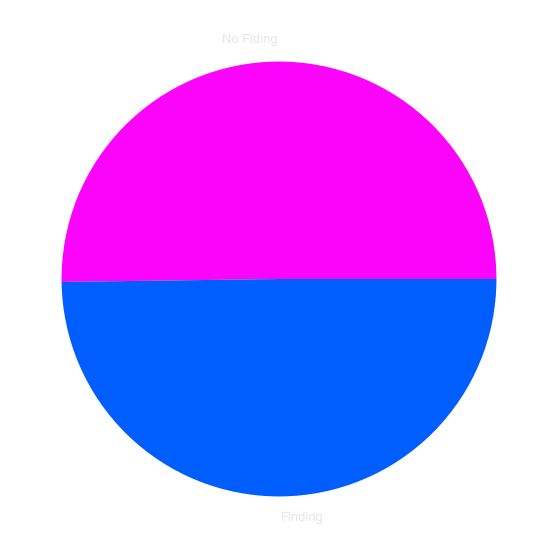

In [66]:
aux = {
    "No Fiding": len([x for x in df_binary["No Finding"] if str(x)=="1"]),
    "Finding": len([x for x in df_binary["No Finding"] if str(x)=="0"])
}
plt.rcParams["figure.figsize"] = (10,10)
plt.pie(aux.values(), labels = aux.keys(), textprops={'fontsize': 13}, colors = colors[6:])
plt.show()

In [67]:
# Pasamos a dividir en conjuntos de test, train y validation
train_df, test_df = train_test_split(df_binary, shuffle = True, random_state = 42, test_size = 0.2)
train_df, val_df = train_test_split(train_df, shuffle = True, random_state = 42, test_size = 0.2)
# Guardamos en local como arrays las imágenes para evitar cargas innecesarias
if os.path.isdir(IMAGE_NPY_BINARY):
    train_imgs_b = np.load(IMAGE_NPY_BINARY + '/train.npy')
    test_imgs_b = np.load(IMAGE_NPY_BINARY + '/test.npy')
    val_imgs_b = np.load(IMAGE_NPY_BINARY + '/val.npy')
else:
    train_imgs_b = imgToArray(train_df["Image Index"])
    test_imgs_b = imgToArray(test_df["Image Index"])
    val_imgs_b = imgToArray(val_df["Image Index"])
    
    os.mkdir(IMAGE_NPY_BINARY)
    
    np.save(IMAGE_NPY_BINARY + '/train.npy', train_imgs_b)
    np.save(IMAGE_NPY_BINARY + '/test.npy', test_imgs_b)
    np.save(IMAGE_NPY_BINARY + '/val.npy', val_imgs_b)
    
# Eliminamos el Image Index de los conjuntos
test_df.drop(["Image Index"], axis = 1, inplace = True)
val_df.drop(["Image Index"], axis = 1, inplace = True)
train_df.drop(["Image Index"], axis = 1, inplace = True)
# Separamos en x e y
x_train_b = train_df.iloc[:, :3]
y_train_b = train_df.iloc[:, 3:]


x_test_b = test_df.iloc[:, :2]
y_test_b = test_df.iloc[:, 3:]


x_val_b = val_df.iloc[:, :2]
y_val_b = val_df.iloc[:, 3:]

### Entrenamiento

#### Primera prueba con las imágenes originales

In [32]:
model = keras.models.Sequential([
    keras.layers.Conv2D(8, 3, activation="relu", padding="same", input_shape=[128, 128, 1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=14)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=314)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1337)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1864)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(12, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16))
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0005), metrics=["binary_accuracy"])

plot_callback = MyCallback()

history = model.fit(
    np.expand_dims(train_imgs_b, axis = 3),
    y_train_b,
    epochs=25,
    validation_data=(np.expand_dims(val_imgs_b, axis = 3), y_val_b),
    batch_size=128,
    callbacks = [
        plot_callback,
    ],
    verbose = 0
)

Finished: {'loss': 0.5882645845413208, 'binary_accuracy': 0.7021888494491577, 'val_loss': 0.603450357913971, 'val_binary_accuracy': 0.6839945316314697}


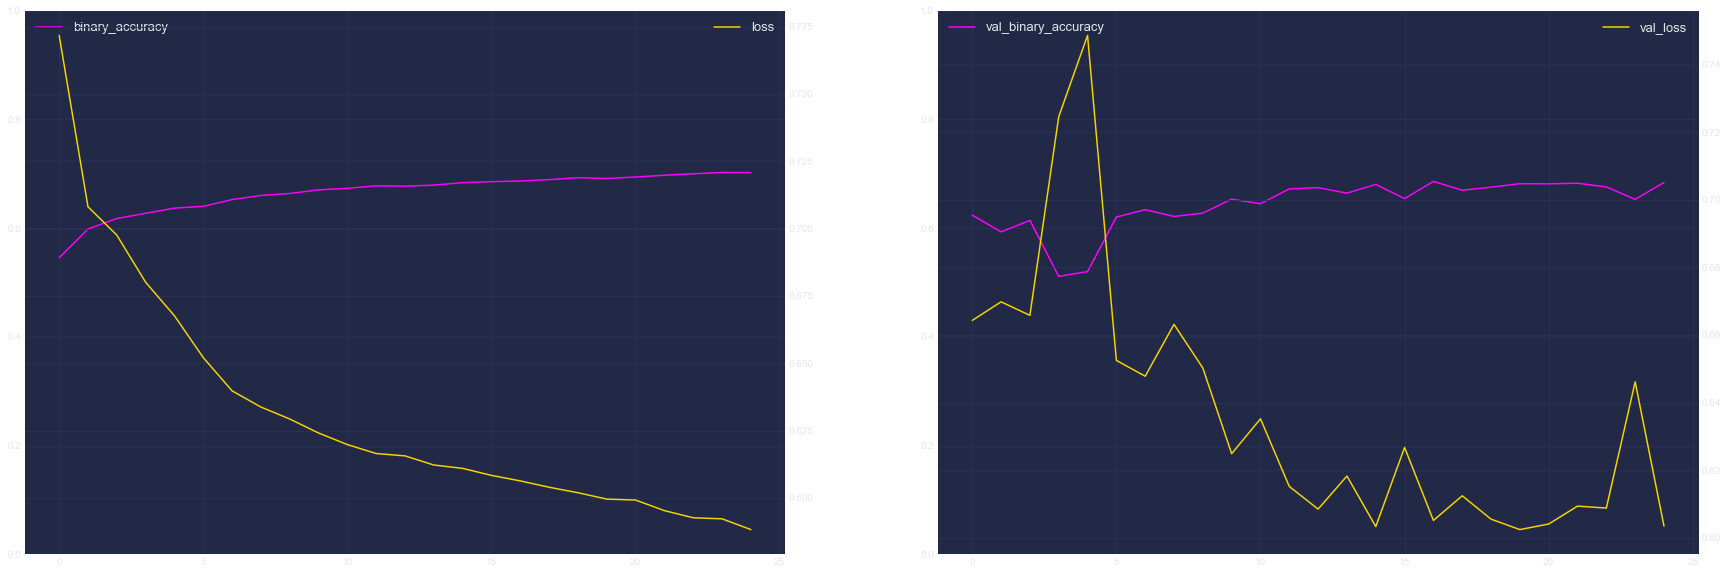

In [33]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [34]:
test_loss = model.evaluate(np.expand_dims(test_imgs_b, axis = 3),  y_test_b, verbose=2)

486/486 - 4s - loss: 0.6024 - binary_accuracy: 0.6827 - 4s/epoch - 8ms/step


In [35]:
pred = model.predict(np.expand_dims(test_imgs_b, axis = 3))
pred = pd.DataFrame(pred, columns=y_test_b.columns)
aux = y_test_b.reset_index(drop = True)
aux2 = pd.concat([pred, aux], axis=1)
aux2.columns = ["Predicted", "Label"]
aux2.tail(20).style.apply(highlight_grthan, props='color:black;background-color:#9859f0;border-color:white', axis=1, n = 0.5)

,Predicted,Label
15514,0.637171,0
15515,0.171695,0
15516,0.469643,1
15517,0.435801,1
15518,0.670801,0
15519,0.248782,0
15520,0.849731,1
15521,0.365050,0
15522,0.175298,0
15523,0.299462,0


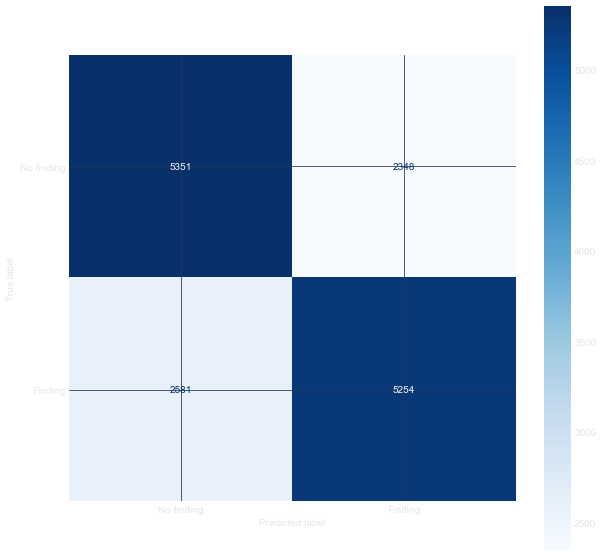

In [36]:
plt.rcParams["figure.figsize"] = (10,10)
y_test_b.to_numpy()
aux = [1 if i >= 0.5 else 0 for i in pred.to_numpy()]
aux = confusion_matrix(y_test_b.to_numpy(), aux)
aux = ConfusionMatrixDisplay(confusion_matrix = aux, display_labels = ["No finding", "Finding"])
aux.plot(cmap=plt.cm.Blues)
plt.show()

#### Segunda prueba con las imágenes normalizadas

In [32]:
def normalizeBinary():
    mean = np.mean(np.concatenate((test_imgs_b, train_imgs_b, val_imgs_b), axis = 0))
    std = np.std(np.concatenate((test_imgs_b, train_imgs_b, val_imgs_b), axis = 0))
    
    new_train_imgs_b = (train_imgs_b - mean) / std
    new_test_imgs_b = (test_imgs_b - mean) / std
    new_val_imgs_b = (val_imgs_b - mean) / std
    return new_train_imgs_b, new_test_imgs_b, new_val_imgs_b

new_train_imgs_b, new_test_imgs_b, new_val_imgs_b = normalizeBinary()

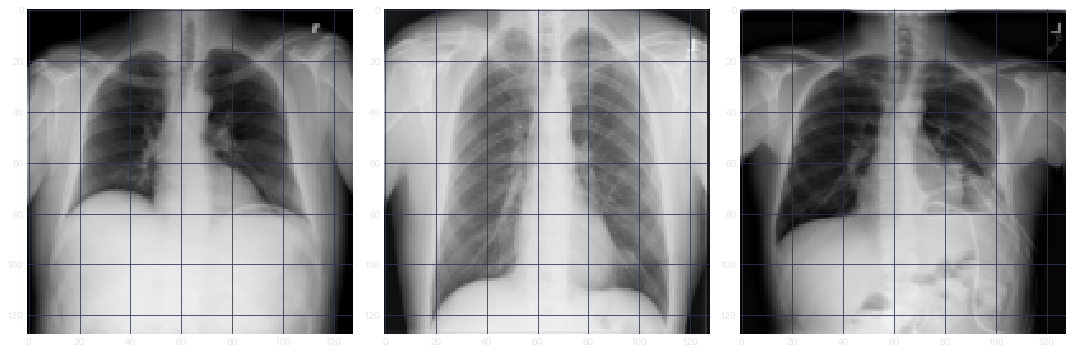

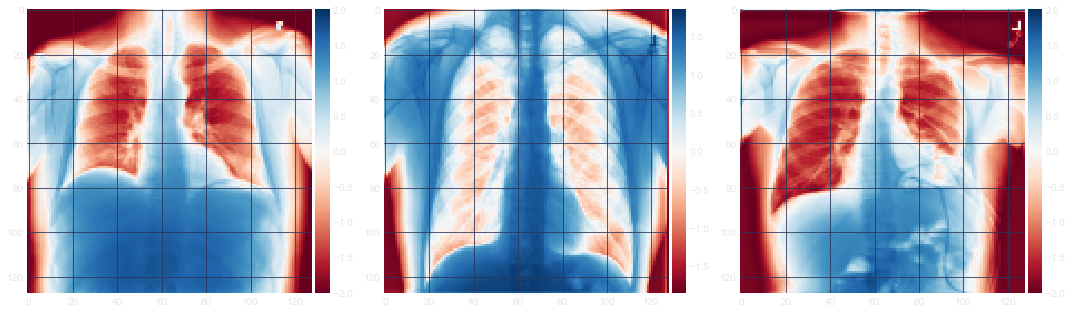

In [33]:
plt.rcParams["figure.figsize"] = (15,15)
plt.subplot(2, 3, 1)
sima.io.imshow(val_imgs_b[0])
plt.subplot(2, 3, 2)
sima.io.imshow(val_imgs_b[1])
plt.subplot(2, 3, 3)
sima.io.imshow(val_imgs_b[2])
plt.show()
plt.subplot(2, 3, 1)
sima.io.imshow(new_val_imgs_b[0])
plt.subplot(2, 3, 2)
sima.io.imshow(new_val_imgs_b[1])
plt.subplot(2, 3, 3)
sima.io.imshow(new_val_imgs_b[2])
plt.show()

In [35]:
model = keras.models.Sequential([
    keras.layers.Conv2D(8, 3, activation="relu", padding="same", input_shape=[128, 128, 1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=14)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=13)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=314)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1337)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1864)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(12, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=16))
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = 0.0001), metrics=["binary_accuracy"])

plot_callback = MyCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

history = model.fit(
    np.expand_dims(new_train_imgs_b, axis = 3),
    y_train_b,
    epochs=10,
    validation_data=(np.expand_dims(new_val_imgs_b, axis = 3), y_val_b),
    batch_size=8,
    callbacks = [
        plot_callback,
        early_stopping,
    ],
    verbose = 0
)

Finished: {'loss': 0.6257548928260803, 'binary_accuracy': 0.666881263256073, 'val_loss': 0.6217866539955139, 'val_binary_accuracy': 0.6598535180091858}


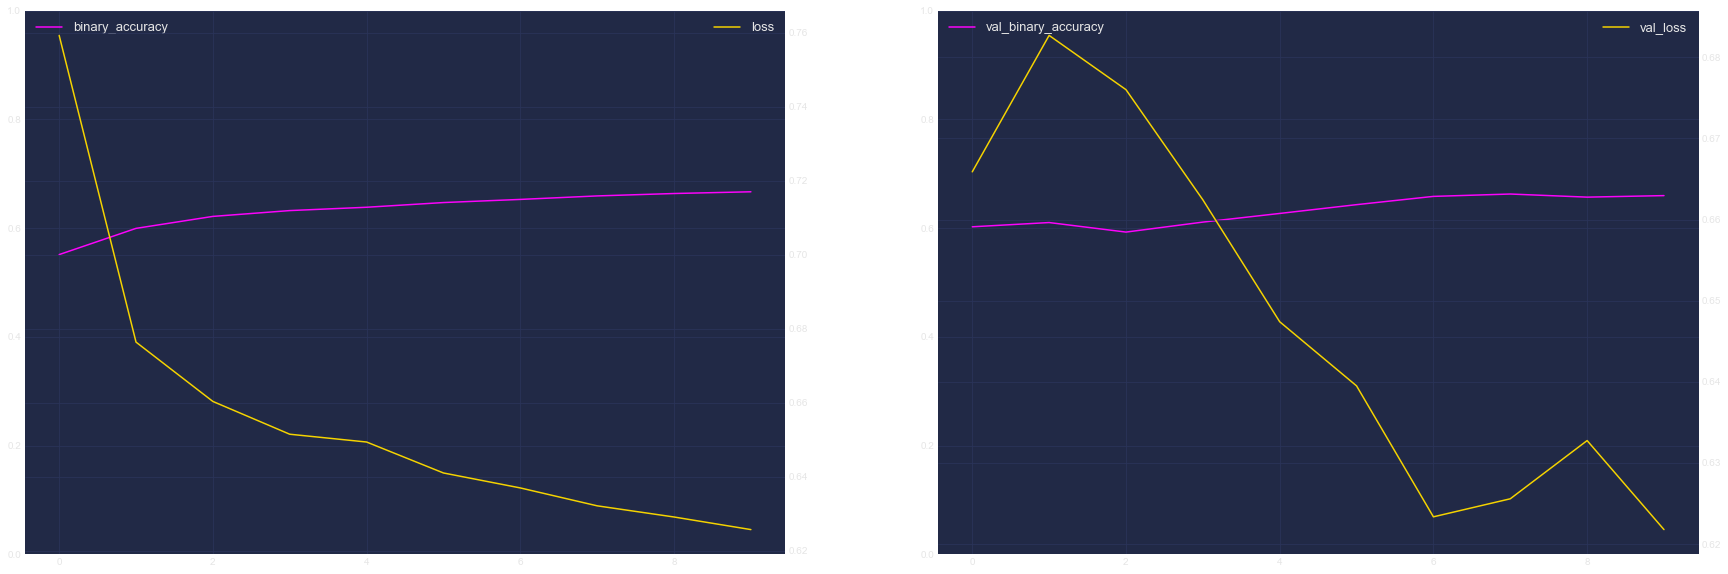

In [36]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [37]:
test_loss = model.evaluate(np.expand_dims(new_test_imgs_b, axis = 3),  y_test_b, verbose=2)

486/486 - 4s - loss: 0.6217 - binary_accuracy: 0.6606 - 4s/epoch - 7ms/step


In [40]:
pred = model.predict(np.expand_dims(new_test_imgs_b, axis = 3))
pred = pd.DataFrame(pred, columns=y_test_b.columns)
aux = y_test_b.reset_index(drop = True)
aux2 = pd.concat([pred, aux], axis=1)
aux2.columns = ["Predicted", "Label"]
aux2.tail(20).style.apply(highlight_grthan, props='color:black;background-color:#9859f0;border-color:white', axis=1, n = 0.5)

,Predicted,Label
15514,0.592460,0
15515,0.345309,0
15516,0.555974,1
15517,0.650282,1
15518,0.692701,0
15519,0.202306,0
15520,0.815361,1
15521,0.586832,0
15522,0.426555,0
15523,0.359943,0


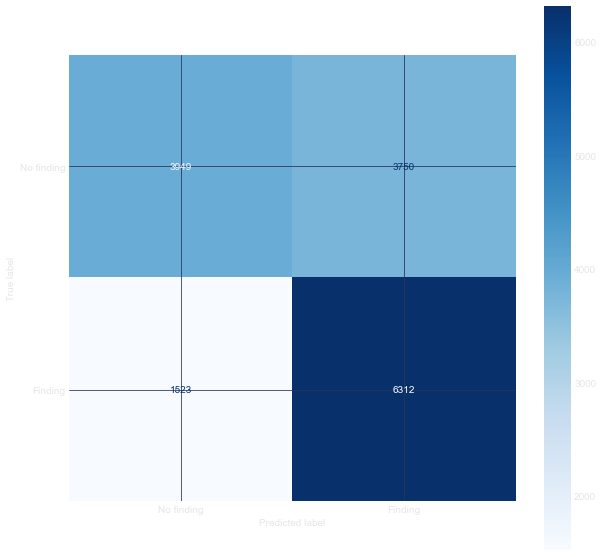

In [42]:
plt.rcParams["figure.figsize"] = (10,10)
y_test_b.to_numpy()
aux = [1 if i >= 0.5 else 0 for i in pred.to_numpy()]
aux = confusion_matrix(y_test_b.to_numpy(), aux)
aux = ConfusionMatrixDisplay(confusion_matrix = aux, display_labels = ["No finding", "Finding"])
aux.plot(cmap=plt.cm.Blues)
plt.show()

## Transfer Learning

### Todas las enfermedades

In [25]:
base_model = keras.applications.VGG19(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

x = tf.keras.applications.vgg19.preprocess_input(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64)(x)
outputs = keras.layers.Dense(8, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832 

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

En primer lugar debemos hacer que las imágenes tengan el shape especificado por la red, en este caso (128, 128, 3)

In [27]:
rgb_train_imgs = train_imgs
rgb_train_imgs = sima.color.gray2rgb(rgb_train_imgs)

rgb_test_imgs = test_imgs
rgb_test_imgs = sima.color.gray2rgb(rgb_test_imgs)

rgb_val_imgs = val_imgs
rgb_val_imgs = sima.color.gray2rgb(rgb_val_imgs)

Podemos comprobar que las imágenes en si no han cambiado:

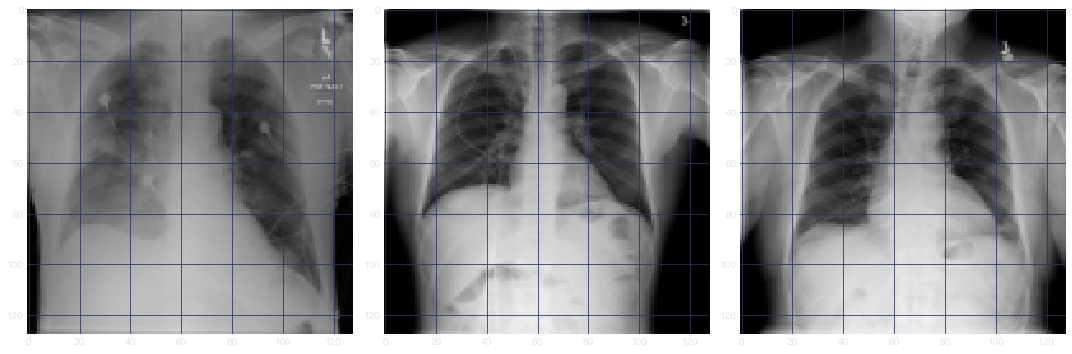

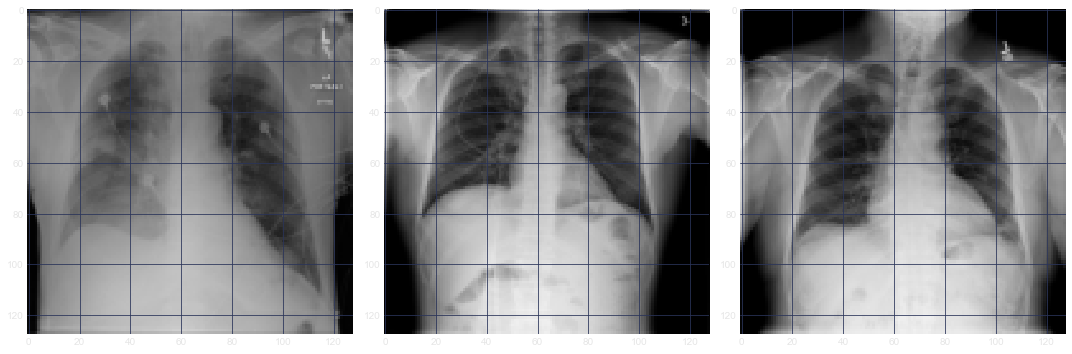

In [28]:
plt.rcParams["figure.figsize"] = (15,15)
plt.subplot(2, 3, 1)
sima.io.imshow(rgb_train_imgs[0])
plt.subplot(2, 3, 2)
sima.io.imshow(rgb_train_imgs[1])
plt.subplot(2, 3, 3)
sima.io.imshow(rgb_train_imgs[2])
plt.show()
plt.subplot(2, 3, 1)
sima.io.imshow(train_imgs[0])
plt.subplot(2, 3, 2)
sima.io.imshow(train_imgs[1])
plt.subplot(2, 3, 3)
sima.io.imshow(train_imgs[2])
plt.show()

En cambio el shape si ha cambiado

In [29]:
print(train_imgs[0].shape, rgb_train_imgs[0].shape)

(128, 128) (128, 128, 3)


In [30]:
model.fit(rgb_train_imgs, y_train, epochs=10, validation_data=(rgb_val_imgs, y_val))

Epoch 1/10
156/156 [==============================] - 12s 51ms/step - loss: 0.7540 - binary_accuracy: 0.7988 - val_loss: 0.5556 - val_binary_accuracy: 0.8252
Epoch 2/10
156/156 [==============================] - 7s 46ms/step - loss: 0.4917 - binary_accuracy: 0.8304 - val_loss: 0.5359 - val_binary_accuracy: 0.8421
Epoch 3/10
156/156 [==============================] - 7s 46ms/step - loss: 0.4281 - binary_accuracy: 0.8460 - val_loss: 0.4794 - val_binary_accuracy: 0.8187
Epoch 4/10
156/156 [==============================] - 7s 47ms/step - loss: 0.4077 - binary_accuracy: 0.8496 - val_loss: 0.4673 - val_binary_accuracy: 0.8339
Epoch 5/10
156/156 [==============================] - 7s 48ms/step - loss: 0.3939 - binary_accuracy: 0.8524 - val_loss: 0.4443 - val_binary_accuracy: 0.8417
Epoch 6/10
156/156 [==============================] - 8s 50ms/step - loss: 0.3770 - binary_accuracy: 0.8564 - val_loss: 0.4669 - val_binary_accuracy: 0.8311
Epoch 7/10
156/156 [==============================] - 9s 

In [31]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(rgb_train_imgs, y_train, epochs=10, validation_data=(rgb_val_imgs, y_val))

Epoch 1/10
156/156 [==============================] - 22s 130ms/step - loss: 0.3254 - binary_accuracy: 0.8732 - val_loss: 0.4159 - val_binary_accuracy: 0.8488
Epoch 2/10
156/156 [==============================] - 24s 151ms/step - loss: 0.3115 - binary_accuracy: 0.8780 - val_loss: 0.4181 - val_binary_accuracy: 0.8462
Epoch 3/10
156/156 [==============================] - 20s 125ms/step - loss: 0.3009 - binary_accuracy: 0.8812 - val_loss: 0.4191 - val_binary_accuracy: 0.8462
Epoch 4/10
156/156 [==============================] - 19s 124ms/step - loss: 0.2909 - binary_accuracy: 0.8852 - val_loss: 0.4238 - val_binary_accuracy: 0.8442
Epoch 5/10
156/156 [==============================] - 19s 124ms/step - loss: 0.2812 - binary_accuracy: 0.8894 - val_loss: 0.4286 - val_binary_accuracy: 0.8444
Epoch 6/10
156/156 [==============================] - 20s 125ms/step - loss: 0.2717 - binary_accuracy: 0.8933 - val_loss: 0.4330 - val_binary_accuracy: 0.8420
Epoch 7/10
156/156 [==========================

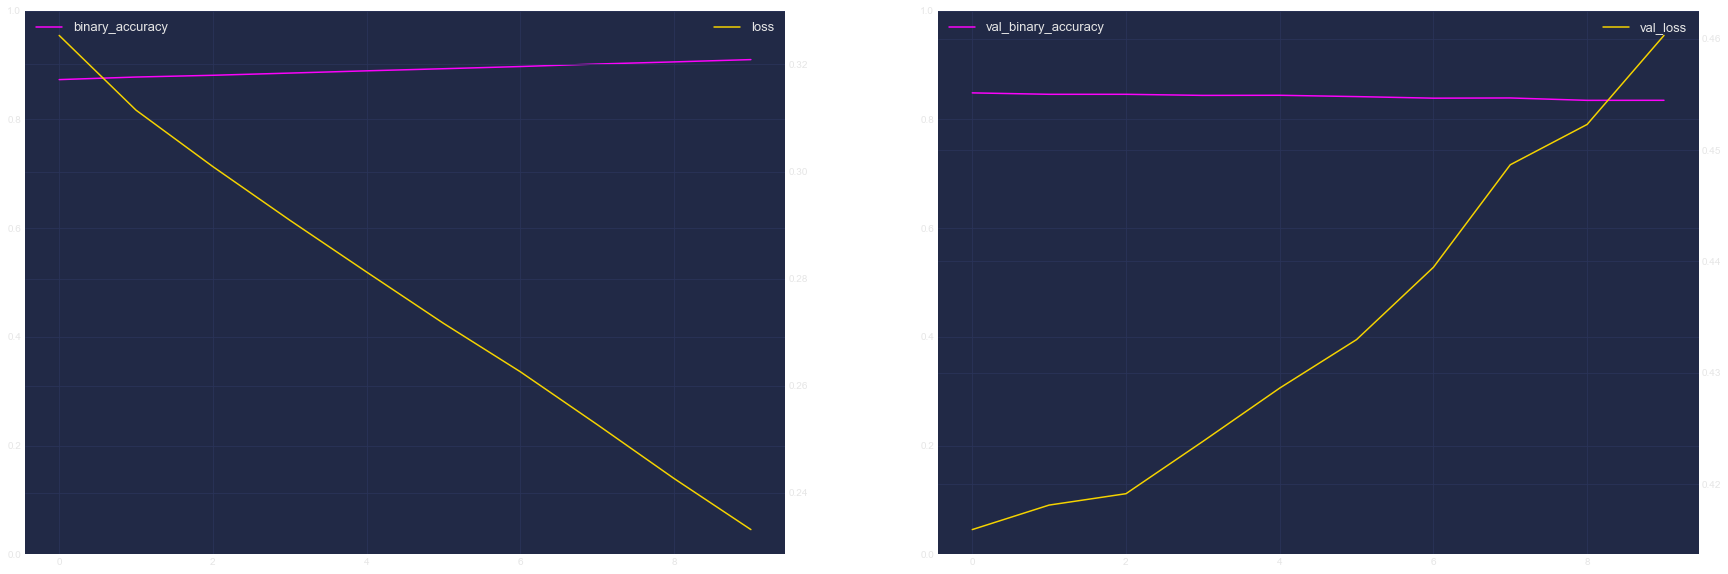

In [32]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[2 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [33]:
model.evaluate(rgb_test_imgs,  y_test, verbose=2)

49/49 - 2s - loss: 0.4570 - binary_accuracy: 0.8334 - 2s/epoch - 47ms/step


[0.45695099234580994, 0.8334403038024902]

In [34]:
pred = model.predict(rgb_test_imgs)
pred = pd.DataFrame(pred, columns=y_test.columns)
pred.head(10).style.apply(highlight_grthan, props='color:black;background-color:#9859f0;', axis=1, n = 0.5)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
0,0.032411,0.018311,0.021272,0.045508,0.356527,0.019415,0.361463,0.463349
1,0.008046,0.073302,0.017008,0.313726,0.395960,0.017204,0.034333,0.115369
2,0.751776,0.030939,0.006951,0.129730,0.036721,0.035610,0.389162,0.044876
3,0.260273,0.024182,0.414939,0.083528,0.186107,0.057681,0.061339,0.079212
4,0.074288,0.016688,0.014810,0.040807,0.014266,0.005219,0.003847,0.774208
5,0.016935,0.036190,0.078717,0.075742,0.069035,0.000891,0.549662,0.015040
6,0.416258,0.012794,0.015517,0.054153,0.035862,0.264723,0.502937,0.212295
7,0.001179,0.044315,0.016431,0.666872,0.278430,0.000178,0.497812,0.003651
8,0.326956,0.004850,0.047748,0.062929,0.052266,0.236000,0.151015,0.057020
9,0.007875,0.096764,0.538278,0.015900,0.155992,0.223030,0.019044,0.199437


In [35]:
y_test.head(10).style.apply(highlight_max, props='color:black;background-color:#9859f0;', axis=1)

,Effusion,No Finding,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Consolidation
7324,0,0,0,0,1,0,0,0
4694,0,1,0,0,0,0,0,0
1322,0,0,0,1,0,0,0,0
5106,0,0,1,0,0,0,0,0
101,0,0,0,0,0,0,0,1
3653,1,0,0,0,0,0,0,0
3519,0,0,0,0,0,0,1,0
487,0,0,0,1,0,0,0,0
6022,1,0,0,0,0,0,0,0
3274,0,1,0,0,0,0,0,0


### Finding y No Finding

In [68]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(32)(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                             

In [69]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [70]:
rgb_train_imgs = train_imgs_b
rgb_train_imgs = sima.color.gray2rgb(rgb_train_imgs)

rgb_test_imgs = test_imgs_b
rgb_test_imgs = sima.color.gray2rgb(rgb_test_imgs)

rgb_val_imgs = val_imgs_b
rgb_val_imgs = sima.color.gray2rgb(rgb_val_imgs)

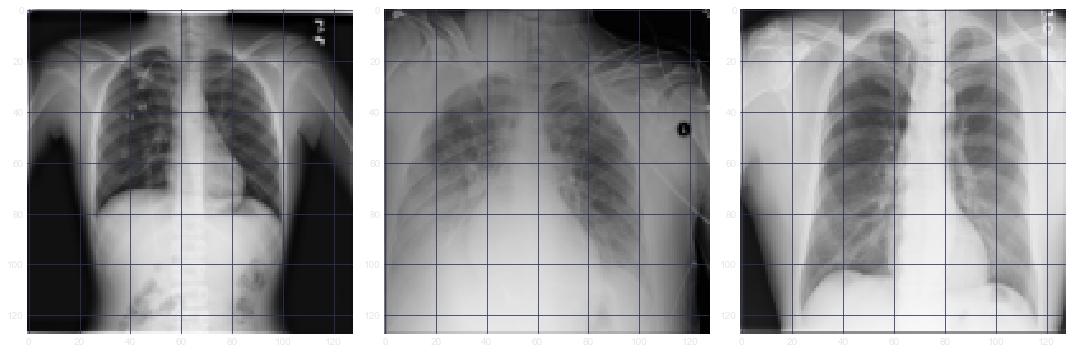

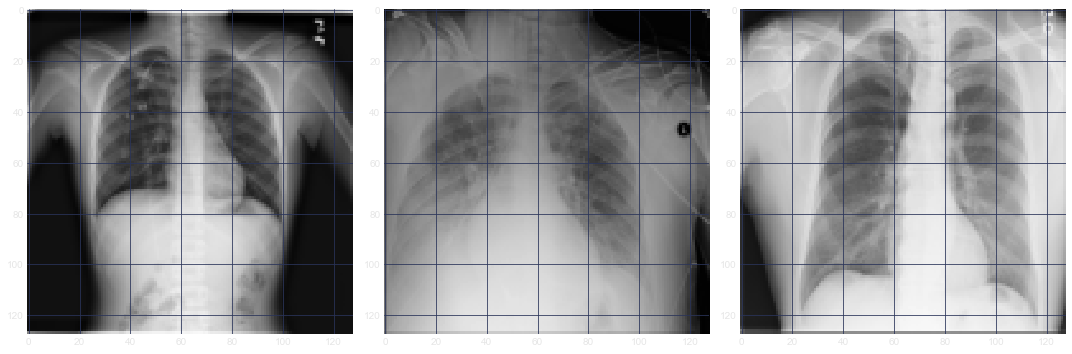

In [71]:
plt.rcParams["figure.figsize"] = (15,15)
plt.subplot(2, 3, 1)
sima.io.imshow(rgb_train_imgs[0])
plt.subplot(2, 3, 2)
sima.io.imshow(rgb_train_imgs[1])
plt.subplot(2, 3, 3)
sima.io.imshow(rgb_train_imgs[2])
plt.show()
plt.subplot(2, 3, 1)
sima.io.imshow(train_imgs_b[0])
plt.subplot(2, 3, 2)
sima.io.imshow(train_imgs_b[1])
plt.subplot(2, 3, 3)
sima.io.imshow(train_imgs_b[2])
plt.show()

In [72]:
print(train_imgs[0].shape, rgb_train_imgs[0].shape)

(128, 128) (128, 128, 3)


In [73]:
model.fit(rgb_train_imgs, y_train_b, epochs=10, validation_data=(rgb_val_imgs, y_val_b), batch_size = 16)

Epoch 1/10
3107/3107 [==============================] - 86s 27ms/step - loss: 0.6618 - binary_accuracy: 0.6291 - val_loss: 0.6346 - val_binary_accuracy: 0.6525
Epoch 2/10
3107/3107 [==============================] - 88s 28ms/step - loss: 0.6359 - binary_accuracy: 0.6490 - val_loss: 0.6318 - val_binary_accuracy: 0.6529
Epoch 3/10
3107/3107 [==============================] - 84s 27ms/step - loss: 0.6338 - binary_accuracy: 0.6527 - val_loss: 0.6321 - val_binary_accuracy: 0.6520
Epoch 4/10
3107/3107 [==============================] - 86s 28ms/step - loss: 0.6307 - binary_accuracy: 0.6546 - val_loss: 0.6335 - val_binary_accuracy: 0.6566
Epoch 5/10
3107/3107 [==============================] - 84s 27ms/step - loss: 0.6286 - binary_accuracy: 0.6568 - val_loss: 0.6345 - val_binary_accuracy: 0.6512
Epoch 6/10
3107/3107 [==============================] - 84s 27ms/step - loss: 0.6273 - binary_accuracy: 0.6572 - val_loss: 0.6302 - val_binary_accuracy: 0.6559
Epoch 7/10
3107/3107 [==================

In [74]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(rgb_train_imgs, y_train_b, epochs=10, validation_data=(rgb_val_imgs, y_val_b))

Epoch 1/10
1554/1554 [==============================] - 241s 152ms/step - loss: 0.6096 - binary_accuracy: 0.6765 - val_loss: 0.6228 - val_binary_accuracy: 0.6669
Epoch 2/10
1554/1554 [==============================] - 244s 157ms/step - loss: 0.5991 - binary_accuracy: 0.6861 - val_loss: 0.6203 - val_binary_accuracy: 0.6678
Epoch 3/10
1554/1554 [==============================] - 243s 156ms/step - loss: 0.5903 - binary_accuracy: 0.6919 - val_loss: 0.6188 - val_binary_accuracy: 0.6702
Epoch 4/10
1554/1554 [==============================] - 249s 160ms/step - loss: 0.5812 - binary_accuracy: 0.7009 - val_loss: 0.6189 - val_binary_accuracy: 0.6698
Epoch 5/10
1554/1554 [==============================] - 284s 183ms/step - loss: 0.5735 - binary_accuracy: 0.7055 - val_loss: 0.6210 - val_binary_accuracy: 0.6709
Epoch 6/10
1554/1554 [==============================] - 236s 152ms/step - loss: 0.5655 - binary_accuracy: 0.7110 - val_loss: 0.6217 - val_binary_accuracy: 0.6665
Epoch 7/10
1554/1554 [======

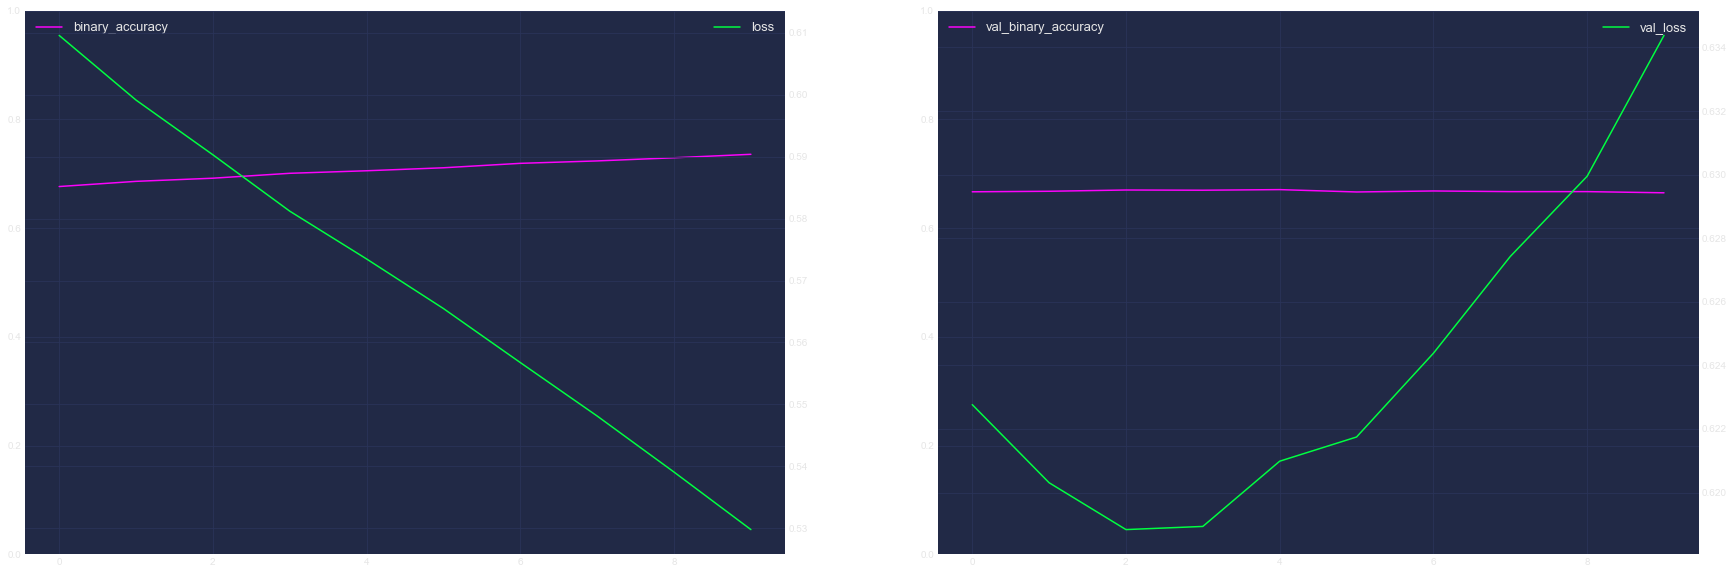

In [75]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1, 2)
for key in history.history.keys():
    col = 0
    if key.startswith("val_"):
        col = 1
    if "loss" in key:
        a = ax[col].twinx()
    else:
        a = ax[col]
        a.set_ylim((0,1))
    a.plot(history.history[key], label = key, c = colors[3 if "loss" in key else 6])
    a.legend(loc = "upper right" if "loss" in key else "upper left", prop={'size': 13})

In [76]:
model.evaluate(rgb_test_imgs,  y_test_b, verbose=2)

486/486 - 15s - loss: 0.6420 - binary_accuracy: 0.6624 - 15s/epoch - 31ms/step


[0.6419822573661804, 0.6623535752296448]

In [77]:
pred = model.predict(rgb_test_imgs)
pred = pd.DataFrame(pred, columns=y_test_b.columns)
aux = y_test_b.reset_index(drop = True)
aux2 = pd.concat([pred, aux], axis=1)
aux2.columns = ["Predicted", "Label"]
aux2.tail(20).style.apply(highlight_grthan, props='color:black;background-color:#9859f0;border-color:white', axis=1, n = 0.5)

,Predicted,Label
15514,0.373280,0
15515,0.058851,0
15516,0.610379,1
15517,0.539684,1
15518,0.542427,0
15519,0.129045,0
15520,0.891820,1
15521,0.421133,0
15522,0.567242,0
15523,0.363754,0


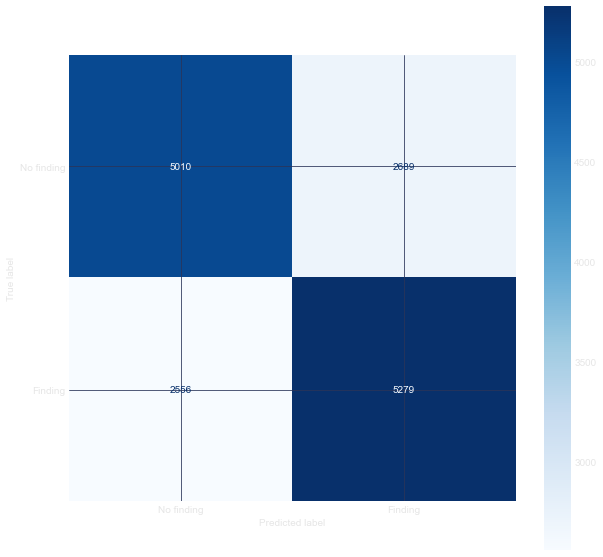

In [78]:
plt.rcParams["figure.figsize"] = (10,10)
y_test_b.to_numpy()
aux = [1 if i >= 0.5 else 0 for i in pred.to_numpy()]
aux = confusion_matrix(y_test_b.to_numpy(), aux)
aux = ConfusionMatrixDisplay(confusion_matrix = aux, display_labels = ["No finding", "Finding"])
aux.plot(cmap=plt.cm.Blues)
plt.show()